### Problem 2:


$$
\begin{cases}
-\Delta u = 1 &\text{on } \Omega\\
u = 0 &\text{on } \partial\Omega
\end{cases}
\label{eqn:problem2}
$$
where $\Omega = (-1,1)\times(-1,1)\setminus[0,1)\times\{0\}$. 
##### In this implementation, we use the penalty method for enforcing boundary conditions.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cbook as cbook
import matplotlib.patches as patches
from ipywidgets import IntProgress
from IPython.display import display
import time

--------------------------------------------------------------------------------------------------------------------------------

# Architectures

## Shallow NN, Tanh Activation

In [4]:
class srnn_Tanh(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.input(x))
        x = self.tanh(self.hidden(x))
        x = self.output(x)
        return x

## Shallow NN, ReLU Activation

In [5]:
class srnn_ReLU(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input(x))
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

## Feedforward NN, tanh Activation

In [6]:
class drfnn_Tanh(nn.Module):
    """
    drfnn2 -- Deep Ritz Feedforward Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.phi = nn.Tanh()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.phi(self.stack[i](x))
        x = self.output(x)
        return x

## Feedforward NN, ReLU Activation

In [7]:
class drfnn_ReLU(nn.Module):
    """
    drnn -- Deep Ritz Feedforward Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.relu(self.stack[i](x))
        x = self.output(x)
        return x

## Original Residual NN, Tanh Activation

In [8]:
class Block(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.Tanh()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [9]:
class drrnn_Tanh(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4):
        super(drrnn_Tanh, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

## Original Residual NN, ReLU Activation

In [10]:
class BlockReLU(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N):
        super(BlockReLU, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.ReLU()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [11]:
class drrnn_ReLU(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4):
        super(drrnn_ReLU, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        #self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(BlockReLU(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

--------------------------------------------------------------------------------------------------------------------------------

# Sampling in $\mathbb{R}^2$

In [12]:
# SQUARE CENTRED AT ORIGIN, SIDE LENGTH 2: \Omega = (-1,1)^2
def get_interior_points_sq(N=128,d=2):
    """
    randomly sample N points from interior of [-1,1]^2
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points_sq(N=32):
    """
    randomly sample N points from boundary of [-1,1]^2
    """
    index1 = torch.rand(N,1) * 2 - 1
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    xb = torch.cat((xb2, xb3, xb4, xb5), dim=0)

    return xb

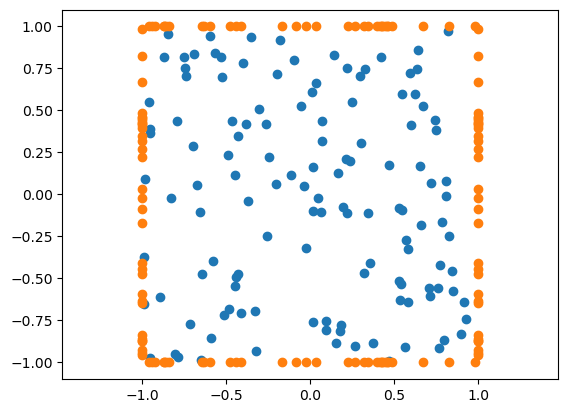

In [13]:
X = get_interior_points_sq()
Y = get_boundary_points_sq()
plt.scatter(X[:,0],X[:,1])
plt.scatter(Y[:,0],Y[:,1])
plt.axis('equal')
plt.show()

In [14]:
# ORIGINAL DOMAIN: \Omega = (-1,1)^2 \ [0,1)x{0}
def get_interior_points_original(N=180,d=2):
    """
    randomly sample N points from interior of (-1,1)^2 \ [0,1)x{0}
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points_original(N=32):
    """
    randomly sample N points from boundary of (-1,1)^2 \ [0,1)x{0}
    """
    index = torch.rand(N,1)
    index1 = torch.rand(N,1) * 2 - 1
    xb1 = torch.cat((index, torch.zeros_like(index)), dim=1)
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    xb = torch.cat((xb1, xb2, xb3, xb4, xb5), dim=0)

    return xb

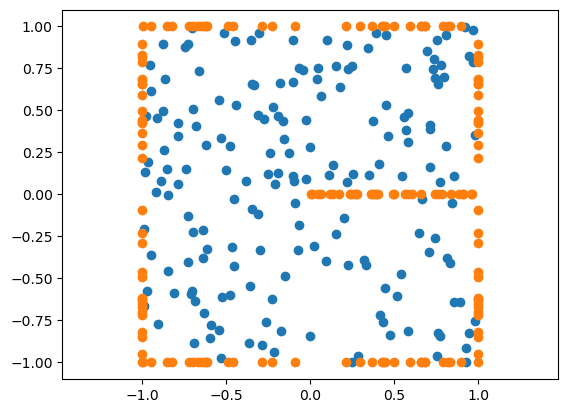

In [15]:
X = get_interior_points_original()
Y = get_boundary_points_original()
plt.scatter(X[:,0],X[:,1])
plt.scatter(Y[:,0],Y[:,1])
plt.axis('equal')
plt.show()

In [16]:
# SWITCHBOARD FOR DOMAINS
def get_points(domain='sq', density=128):
    """
    Switchboard for domains
    """
    if domain == 'original':
        xr = get_interior_points_original()
        xb = get_boundary_points_original()
        
    else:
        xr = get_interior_points_sq(N=density)
        xb = get_boundary_points_sq()
        
    return xr, xb

--------------------------------------------------------------------------------------------------------------------------------

# Initialisation and Training

In [17]:
def weights_init(m):  # Initialise weights
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)      # Initialisation technique using normal dist. introduced by Xavier Glorot
        nn.init.constant_(m.bias, 0.0)        # Initialise bias vectors as zero

--------------------------------------------------------------------------------------------------------------------------------

# Original Problem

In [19]:
def main_original(domain = 'original', density=19, arch = 'drrnn_Tanh', epochs = 5000,
                  weight1=1, weight2=500, m = 10, lr=3e-3, pretrain=0, save=1):    
    """
    main -- Training Module

    Trains a chosen model with random sampling in domain and boundary.

    Parameters:
        domain -- domain of the problem
        arch   -- architecture to be used
        m      -- width of layers
    """

    in_N = 2      # Input Dimensions
    out_N = 1     # Output Dimensions

    device = torch.device('cpu')
    
    if arch == 'srnn_ReLU':
        model = srnn_ReLU(in_N, m, out_N).to(device)
    elif arch == 'srnn_Tanh':
        model = srnn_Tanh(in_N, m, out_N).to(device)
    elif arch == 'drfnn_ReLU':
        model = drfnn_ReLU(in_N, m, out_N).to(device)
    elif arch == 'drfnn_Tanh':
        model = drfnn_Tanh(in_N, m, out_N).to(device)
    elif arch == 'drrnn_ReLU':
        model = drrnn_ReLU(in_N, m, out_N).to(device)
    else:
        arch = 'drrnn_Tanh'
        model = drrnn_Tanh(in_N, m, out_N).to(device)
        


    
    # Initialise weights
    if pretrain == 1:
        model.load_state_dict(torch.load('pretrained_models/'+domain+'_'+arch+'.mdl'))
    else:
        model.apply(weights_init)  
        
        # PLOT EXAMPLE DATA
        X, Y = get_points(domain, density)
        plt.scatter(X[:,0],X[:,1])
        plt.scatter(Y[:,0],Y[:,1])
        plt.axis('equal')
        plt.show()
        

    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(arch)  #print(model)                                
    
    save_loss = torch.zeros((epochs//100, 1))                 # saving loss and error values as the model is trained
    best_loss, best_epoch = 100000, 0     # Tracking best iteration
    
    f = IntProgress(min=0, max=epochs//100) # instantiate the bar
    display(f) # display the bar
    
    for epoch in range(epochs+1):

        xr, xb = get_points(domain, density)                           # Generate data
        xr = xr.to(device)
        xb = xb.to(device)
        
        xr.requires_grad_()
        output_r = model(xr)
        output_b = model(xb)
        
        # Compute the gradient term \nabla v
        grads = autograd.grad(outputs=output_r, inputs=xr,
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

        # Integrand of variational problem (average)
        loss_r = 0.5 * torch.sum(torch.pow(grads, 2),dim=1) - output_r
        loss_r = torch.mean(loss_r)
        
        # Boundary data penalty term
        loss_b = torch.mean(torch.pow(output_b,2))
        
        loss = weight1 * 4 * loss_r + weight2 * 9 * loss_b       # Oiginal weighting, 
        # 4 = area of Omega, 9 = length of boundary

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            #'''
            print('epoch:', epoch, 'loss:', loss.item(), 'loss_r:', (weight1 * 4 * loss_r).item(), 'loss_b:', (weight2 * 9 * loss_b).item())
            save_loss[epoch//100 - 1] = loss.item()
            
            f.value += 1 # signal to increment the progress bar
            time.sleep(.1)

            # Find minimum absolute loss in final 20% of training process
            if epoch > int(4 * epochs / 5):
                if (loss.item() < best_loss): #(error.item() < best_error):       # Most negative value of loss
                    best_loss = loss.item()
                    best_epoch = epoch
                    if pretrain == 2 or pretrain == 1:
                        torch.save(model.state_dict(), 'pretrained_models/'+domain+'_'+arch+'.mdl')   
                    torch.save(model.state_dict(), 'saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl')
    print('best epoch:', best_epoch, 'best loss:', best_loss)

    # plot figure
    model.load_state_dict(torch.load('saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl'))
    print('load from ckpt!')
    
    num_points=1001
    x = torch.linspace(-1, 1, num_points)
    Y, X = torch.meshgrid(x, x)

    # EVALUATE MODEL IN [-1,1]^2
    Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
    Z = Z.to(device)
    with torch.no_grad():
        pred = model(Z)
        
    pred = pred.cpu().numpy()
    pred = pred.reshape(1001, 1001)
    # PLOT
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    h = plt.imshow(pred, interpolation='nearest', cmap='jet',
               extent = [-1,1,-1,1],
               origin='lower', aspect='equal',
               vmin=np.nanmin(pred), vmax=np.nanmax(pred))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    if save == 1:
        plt.savefig('network_solutions/'+domain+'_'+arch+str(epochs)+'_pred.png')
    plt.show()
    
    # Loss and Error profile
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Iterations (100s)')
    ax1.set_ylabel('Loss', color=color)
    #ax1.set_yscale('log')
    ax1.plot(save_loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Training Loss and Error Profiles")
    '''ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('L2 Error From Sample', color=color)  
    ax2.set_yscale('log')
    ax2.plot(save_error, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()'''  
    #plt.savefig('original_'+arch+str(epochs)+'_loss.png')
    if save == 1:
        plt.savefig('convergence_plots/'+domain+'_'+arch+str(epochs)+'_combined.png')
    plt.show()

### Shallow NN, Tanh Activation

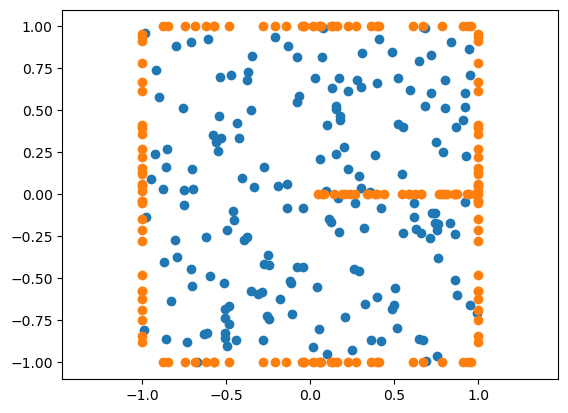

srnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 612.7125854492188 loss_r: 0.6196178197860718 loss_b: 612.0929565429688
epoch: 100 loss: 0.7364943623542786 loss_r: -0.0068479194305837154 loss_b: 0.7433422803878784
epoch: 200 loss: 0.25740930438041687 loss_r: -0.003261721460148692 loss_b: 0.2606710195541382
epoch: 300 loss: 0.06427620351314545 loss_r: -0.004351276438683271 loss_b: 0.06862747669219971
epoch: 400 loss: 0.0126937385648489 loss_r: -0.0033783356193453074 loss_b: 0.016072073951363564
epoch: 500 loss: 0.0016375405248254538 loss_r: -0.0035594983492046595 loss_b: 0.005197038874030113
epoch: 600 loss: -0.0009755031205713749 loss_r: -0.004130373243242502 loss_b: 0.0031548701226711273
epoch: 700 loss: -0.0019772809464484453 loss_r: -0.004331192933022976 loss_b: 0.0023539119865745306
epoch: 800 loss: -0.0019163661636412144 loss_r: -0.004452847875654697 loss_b: 0.002536481712013483
epoch: 900 loss: -0.002265758579596877 loss_r: -0.004495494998991489 loss_b: 0.0022297364193946123
epoch: 1000 loss: -0.00214728130958974

/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


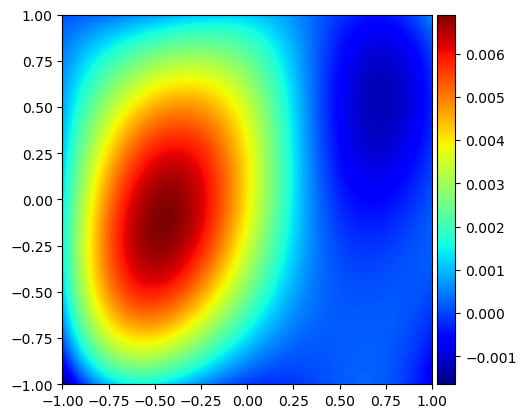

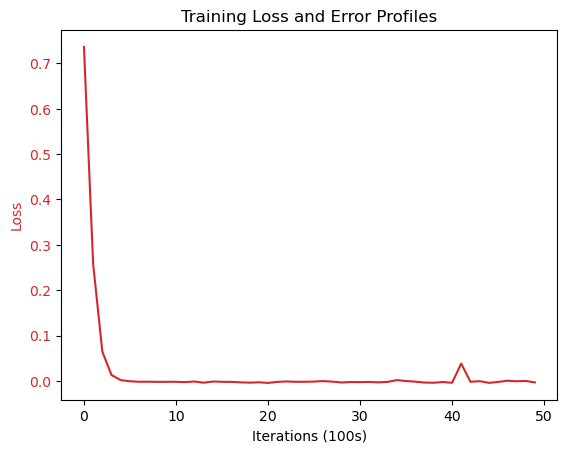

In [36]:
main_original(domain='original', arch='srnn_Tanh', epochs=5000, pretrain=2)

srnn_Tanh


IntProgress(value=0, max=250)

epoch: 0 loss: -0.0030848709866404533 loss_r: -0.007683661766350269 loss_b: 0.004598790779709816
epoch: 100 loss: -0.004696190357208252 loss_r: -0.007800444960594177 loss_b: 0.003104254836216569
epoch: 200 loss: -0.004292828496545553 loss_r: -0.008219227194786072 loss_b: 0.003926398698240519
epoch: 300 loss: -0.004312316887080669 loss_r: -0.008127620443701744 loss_b: 0.003815303323790431
epoch: 400 loss: -0.0036341259256005287 loss_r: -0.008092505857348442 loss_b: 0.004458379931747913
epoch: 500 loss: -0.004731167107820511 loss_r: -0.007483766879886389 loss_b: 0.0027525995392352343
epoch: 600 loss: -0.004943648353219032 loss_r: -0.008816612884402275 loss_b: 0.003872964298352599
epoch: 700 loss: -0.001706787385046482 loss_r: -0.006240678019821644 loss_b: 0.004533890634775162
epoch: 800 loss: -0.006415951997041702 loss_r: -0.009776887483894825 loss_b: 0.0033609357196837664
epoch: 900 loss: -0.001956040970981121 loss_r: -0.008820904418826103 loss_b: 0.006864863447844982
epoch: 1000 loss: 

epoch: 8400 loss: 0.007651009596884251 loss_r: -0.014921587891876698 loss_b: 0.022572597488760948
epoch: 8500 loss: -0.007444584742188454 loss_r: -0.016959168016910553 loss_b: 0.0095145832747221
epoch: 8600 loss: -0.008753817528486252 loss_r: -0.013603596948087215 loss_b: 0.004849779419600964
epoch: 8700 loss: 0.0016158297657966614 loss_r: -0.0167799424380064 loss_b: 0.018395772203803062
epoch: 8800 loss: -0.003720366396009922 loss_r: -0.015526684001088142 loss_b: 0.01180631760507822
epoch: 8900 loss: -0.006532452534884214 loss_r: -0.013431831263005733 loss_b: 0.006899378728121519
epoch: 9000 loss: -0.010161912068724632 loss_r: -0.021688900887966156 loss_b: 0.011526988819241524
epoch: 9100 loss: -0.012673763558268547 loss_r: -0.017679903656244278 loss_b: 0.005006140097975731
epoch: 9200 loss: -0.005869429558515549 loss_r: -0.020942099392414093 loss_b: 0.015072669833898544
epoch: 9300 loss: -0.010515440255403519 loss_r: -0.015117472037672997 loss_b: 0.004602032247930765
epoch: 9400 loss

epoch: 16700 loss: -0.02068938873708248 loss_r: -0.03924812376499176 loss_b: 0.01855873502790928
epoch: 16800 loss: -0.016948338598012924 loss_r: -0.02738356590270996 loss_b: 0.010435227304697037
epoch: 16900 loss: -0.019524652510881424 loss_r: -0.041329000145196915 loss_b: 0.02180434763431549
epoch: 17000 loss: -0.024963969364762306 loss_r: -0.04014597833156586 loss_b: 0.01518200896680355
epoch: 17100 loss: -0.01984325423836708 loss_r: -0.044855356216430664 loss_b: 0.025012101978063583
epoch: 17200 loss: -0.007760804146528244 loss_r: -0.04140935465693474 loss_b: 0.033648550510406494
epoch: 17300 loss: -0.023042939603328705 loss_r: -0.04523371160030365 loss_b: 0.022190771996974945
epoch: 17400 loss: -0.02944033220410347 loss_r: -0.04265905171632767 loss_b: 0.013218719512224197
epoch: 17500 loss: -0.021412856876850128 loss_r: -0.05038609355688095 loss_b: 0.028973236680030823
epoch: 17600 loss: -0.030662288889288902 loss_r: -0.052435051649808884 loss_b: 0.02177276276051998
epoch: 17700 l

/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


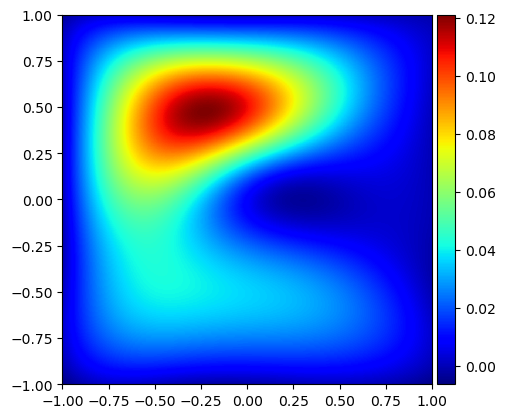

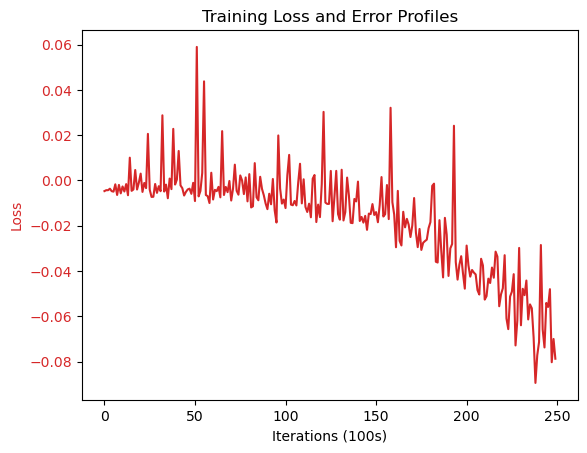

In [17]:
main_original(domain='original', arch='srnn_Tanh', epochs=25000, pretrain=1)

srnn_Tanh


IntProgress(value=0, max=300)

epoch: 0 loss: -0.0650845468044281 loss_r: -0.07926285266876221 loss_b: 0.014178303070366383
epoch: 100 loss: -0.08753576874732971 loss_r: -0.09805509448051453 loss_b: 0.010519322007894516
epoch: 200 loss: -0.07904790341854095 loss_r: -0.09392330050468445 loss_b: 0.014875396154820919
epoch: 300 loss: -0.06350906193256378 loss_r: -0.08029288053512573 loss_b: 0.01678382232785225
epoch: 400 loss: -0.05583582818508148 loss_r: -0.08813853561878204 loss_b: 0.03230270743370056
epoch: 500 loss: -0.07200073450803757 loss_r: -0.08586582541465759 loss_b: 0.01386509370058775
epoch: 600 loss: -0.07809567451477051 loss_r: -0.09568808227777481 loss_b: 0.017592405900359154
epoch: 700 loss: -0.05202092230319977 loss_r: -0.086449533700943 loss_b: 0.034428611397743225
epoch: 800 loss: -0.07046578824520111 loss_r: -0.08640096336603165 loss_b: 0.015935171395540237
epoch: 900 loss: -0.08675219118595123 loss_r: -0.09698198735713959 loss_b: 0.010229794308543205
epoch: 1000 loss: -0.058172471821308136 loss_r: 

epoch: 8600 loss: -0.10242398828268051 loss_r: -0.11229278147220612 loss_b: 0.009868793189525604
epoch: 8700 loss: -0.11809704452753067 loss_r: -0.13473470509052277 loss_b: 0.016637662425637245
epoch: 8800 loss: -0.10051941871643066 loss_r: -0.12380648404359818 loss_b: 0.02328706532716751
epoch: 8900 loss: -0.0867195725440979 loss_r: -0.10594772547483444 loss_b: 0.01922815479338169
epoch: 9000 loss: -0.12218150496482849 loss_r: -0.13470688462257385 loss_b: 0.012525382451713085
epoch: 9100 loss: -0.10424093157052994 loss_r: -0.12004910409450531 loss_b: 0.01580817438662052
epoch: 9200 loss: -0.1337883472442627 loss_r: -0.1494409441947937 loss_b: 0.015652604401111603
epoch: 9300 loss: -0.06883419305086136 loss_r: -0.08865005522966385 loss_b: 0.01981586217880249
epoch: 9400 loss: -0.1030004695057869 loss_r: -0.1216563731431961 loss_b: 0.01865590363740921
epoch: 9500 loss: -0.09675765782594681 loss_r: -0.1152108907699585 loss_b: 0.018453234806656837
epoch: 9600 loss: -0.08369205892086029 lo

epoch: 17100 loss: -0.1072610467672348 loss_r: -0.11763708293437958 loss_b: 0.0103760389611125
epoch: 17200 loss: -0.10648610442876816 loss_r: -0.12704937160015106 loss_b: 0.020563269034028053
epoch: 17300 loss: -0.10040545463562012 loss_r: -0.12329838424921036 loss_b: 0.022892925888299942
epoch: 17400 loss: -0.12423820048570633 loss_r: -0.13199418783187866 loss_b: 0.00775598781183362
epoch: 17500 loss: -0.12187935411930084 loss_r: -0.13567885756492615 loss_b: 0.013799505308270454
epoch: 17600 loss: -0.09664514660835266 loss_r: -0.10777570307254791 loss_b: 0.011130556464195251
epoch: 17700 loss: -0.10545256733894348 loss_r: -0.13162145018577576 loss_b: 0.026168882846832275
epoch: 17800 loss: -0.09571001678705215 loss_r: -0.12463466823101044 loss_b: 0.028924649581313133
epoch: 17900 loss: -0.09356573224067688 loss_r: -0.10195080190896988 loss_b: 0.008385069668293
epoch: 18000 loss: -0.10145878791809082 loss_r: -0.11204195767641068 loss_b: 0.010583167895674706
epoch: 18100 loss: -0.13996

epoch: 25600 loss: -0.12678828835487366 loss_r: -0.13578563928604126 loss_b: 0.008997350931167603
epoch: 25700 loss: -0.0863879919052124 loss_r: -0.11525513231754303 loss_b: 0.028867144137620926
epoch: 25800 loss: -0.10880520194768906 loss_r: -0.1180475652217865 loss_b: 0.009242362342774868
epoch: 25900 loss: -0.12322794646024704 loss_r: -0.13252340257167816 loss_b: 0.009295458905398846
epoch: 26000 loss: -0.1250990778207779 loss_r: -0.1355150192975998 loss_b: 0.010415934957563877
epoch: 26100 loss: -0.09212741255760193 loss_r: -0.10395151376724243 loss_b: 0.011824100278317928
epoch: 26200 loss: -0.1219356432557106 loss_r: -0.1355104148387909 loss_b: 0.013574772514402866
epoch: 26300 loss: -0.0994589775800705 loss_r: -0.11720963567495346 loss_b: 0.017750658094882965
epoch: 26400 loss: -0.10429767519235611 loss_r: -0.11468242108821869 loss_b: 0.01038474589586258
epoch: 26500 loss: -0.1282760053873062 loss_r: -0.13547244668006897 loss_b: 0.007196448277682066
epoch: 26600 loss: -0.0916544

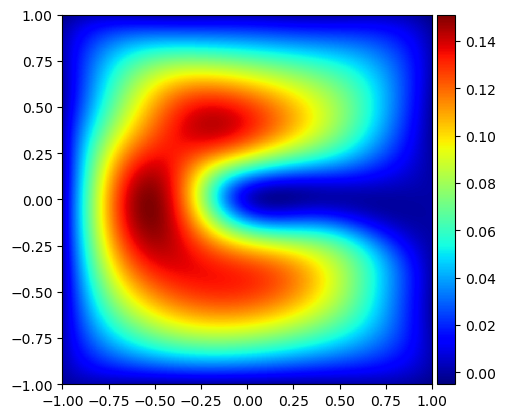

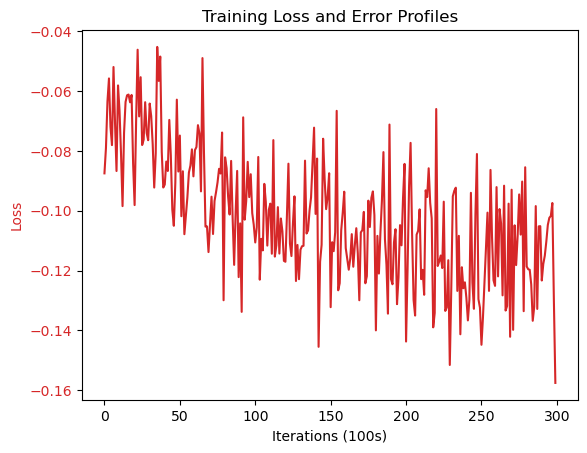

In [18]:
main_original(domain='original', arch='srnn_Tanh', epochs=30000, pretrain=1)

### Shallow NN, Tanh Activation

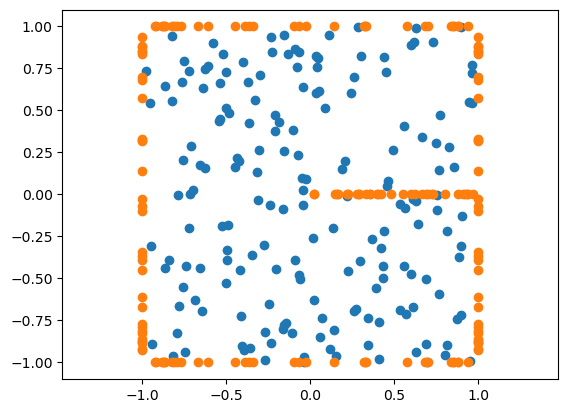

srnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 26.9881649017334 loss_r: 0.13381703197956085 loss_b: 26.854347229003906
epoch: 100 loss: 0.04287860170006752 loss_r: 0.004298705607652664 loss_b: 0.038579896092414856
epoch: 200 loss: 0.009247463196516037 loss_r: -0.003603701712563634 loss_b: 0.012851164676249027
epoch: 300 loss: 2.414872869849205e-05 loss_r: -0.005823553539812565 loss_b: 0.005847702268511057
epoch: 400 loss: -0.0046226331032812595 loss_r: -0.007720001041889191 loss_b: 0.003097367938607931
epoch: 500 loss: -0.00492073455825448 loss_r: -0.007037506904453039 loss_b: 0.002116772346198559
epoch: 600 loss: -0.005553712602704763 loss_r: -0.008144035935401917 loss_b: 0.002590323332697153
epoch: 700 loss: -0.007853110320866108 loss_r: -0.009827102534472942 loss_b: 0.0019739919807761908
epoch: 800 loss: -0.008475368842482567 loss_r: -0.011558221653103828 loss_b: 0.003082852577790618
epoch: 900 loss: -0.008122481405735016 loss_r: -0.011351238936185837 loss_b: 0.0032287579961121082
epoch: 1000 loss: -0.010095990262

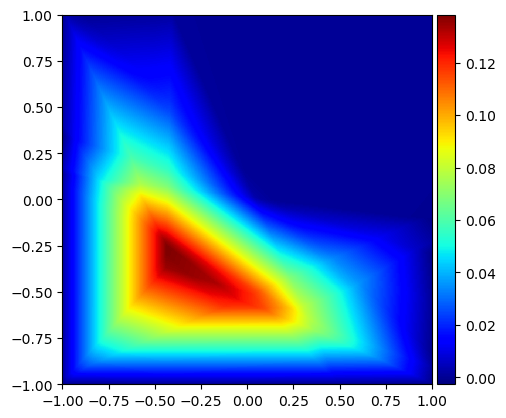

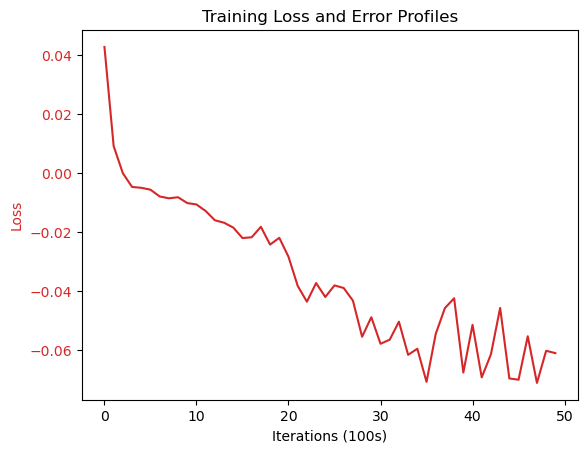

In [31]:
main_original(domain='original', arch='srnn_ReLU', epochs=5000, pretrain=2)

srnn_ReLU


IntProgress(value=0, max=250)

epoch: 0 loss: -0.063484787940979 loss_r: -0.07142322510480881 loss_b: 0.00793843436986208
epoch: 100 loss: -0.06213551387190819 loss_r: -0.065499447286129 loss_b: 0.0033639317844063044
epoch: 200 loss: -0.07308463007211685 loss_r: -0.07690548151731491 loss_b: 0.0038208505138754845
epoch: 300 loss: -0.05892137438058853 loss_r: -0.06324570626020432 loss_b: 0.004324332345277071
epoch: 400 loss: -0.060055747628211975 loss_r: -0.0648421123623848 loss_b: 0.004786365665495396
epoch: 500 loss: -0.07638934254646301 loss_r: -0.0812506452202797 loss_b: 0.004861306399106979
epoch: 600 loss: -0.06289788335561752 loss_r: -0.06392458826303482 loss_b: 0.0010267073521390557
epoch: 700 loss: -0.05922731012105942 loss_r: -0.06189646199345589 loss_b: 0.0026691516395658255
epoch: 800 loss: -0.05738229304552078 loss_r: -0.05891243740916252 loss_b: 0.0015301458770409226
epoch: 900 loss: -0.05065584555268288 loss_r: -0.05454154685139656 loss_b: 0.0038856996688991785
epoch: 1000 loss: -0.07946860790252686 los

epoch: 8500 loss: -0.11324586719274521 loss_r: -0.11732050031423569 loss_b: 0.004074631724506617
epoch: 8600 loss: -0.12275045365095139 loss_r: -0.12433039397001266 loss_b: 0.0015799424145370722
epoch: 8700 loss: -0.12878431379795074 loss_r: -0.13102225959300995 loss_b: 0.0022379455622285604
epoch: 8800 loss: -0.09618274867534637 loss_r: -0.10436520725488663 loss_b: 0.008182459510862827
epoch: 8900 loss: -0.10362375527620316 loss_r: -0.10974635183811188 loss_b: 0.006122599821537733
epoch: 9000 loss: -0.11404287070035934 loss_r: -0.12216120213270187 loss_b: 0.008118330501019955
epoch: 9100 loss: -0.10170843452215195 loss_r: -0.10462164133787155 loss_b: 0.002913207747042179
epoch: 9200 loss: -0.13036906719207764 loss_r: -0.13776077330112457 loss_b: 0.007391706574708223
epoch: 9300 loss: -0.10393545776605606 loss_r: -0.1149691790342331 loss_b: 0.011033719405531883
epoch: 9400 loss: -0.12155935913324356 loss_r: -0.13046513497829437 loss_b: 0.008905773982405663
epoch: 9500 loss: -0.12584231

epoch: 16900 loss: -0.12869928777217865 loss_r: -0.13422010838985443 loss_b: 0.005520820617675781
epoch: 17000 loss: -0.12005728483200073 loss_r: -0.12559619545936584 loss_b: 0.005538914352655411
epoch: 17100 loss: -0.11984883248806 loss_r: -0.1225232407450676 loss_b: 0.002674404764547944
epoch: 17200 loss: -0.1482486128807068 loss_r: -0.1534307301044464 loss_b: 0.00518212141469121
epoch: 17300 loss: -0.1231294795870781 loss_r: -0.12523405253887177 loss_b: 0.0021045743487775326
epoch: 17400 loss: -0.10099685937166214 loss_r: -0.10956016927957535 loss_b: 0.008563308045268059
epoch: 17500 loss: -0.11211542785167694 loss_r: -0.1203005239367485 loss_b: 0.00818509329110384
epoch: 17600 loss: -0.11705025285482407 loss_r: -0.1180744543671608 loss_b: 0.0010242032585665584
epoch: 17700 loss: -0.11042626202106476 loss_r: -0.11487884819507599 loss_b: 0.004452588967978954
epoch: 17800 loss: -0.12984609603881836 loss_r: -0.13243690133094788 loss_b: 0.0025908041279762983
epoch: 17900 loss: -0.107635

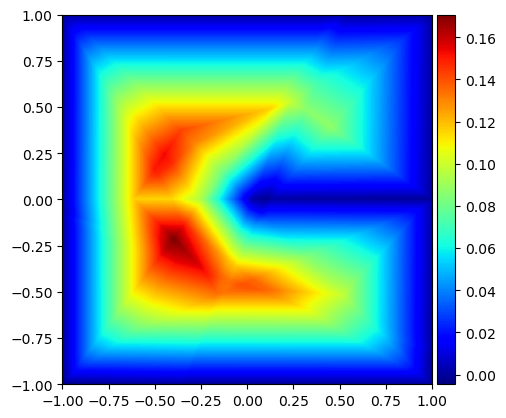

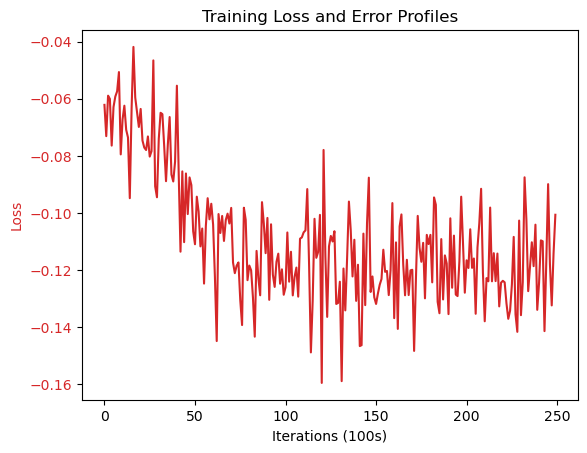

In [32]:
main_original(domain='original', arch='srnn_ReLU', epochs=25000, pretrain=1)

srnn_ReLU


IntProgress(value=0, max=300)

epoch: 0 loss: -0.1297132670879364 loss_r: -0.13298384845256805 loss_b: 0.0032705808989703655
epoch: 100 loss: -0.10311789810657501 loss_r: -0.1061270534992218 loss_b: 0.0030091574881225824
epoch: 200 loss: -0.10805367678403854 loss_r: -0.1106765866279602 loss_b: 0.0026229084469377995
epoch: 300 loss: -0.1158720850944519 loss_r: -0.11875223368406296 loss_b: 0.0028801467269659042
epoch: 400 loss: -0.11215052008628845 loss_r: -0.11643235385417938 loss_b: 0.004281831905245781
epoch: 500 loss: -0.09983696788549423 loss_r: -0.10593117773532867 loss_b: 0.006094209849834442
epoch: 600 loss: -0.13168086111545563 loss_r: -0.13722918927669525 loss_b: 0.00554833235219121
epoch: 700 loss: -0.13469144701957703 loss_r: -0.1355346441268921 loss_b: 0.0008432027534581721
epoch: 800 loss: -0.14432120323181152 loss_r: -0.14752636849880219 loss_b: 0.0032051722519099712
epoch: 900 loss: -0.12899616360664368 loss_r: -0.13309216499328613 loss_b: 0.004095999989658594
epoch: 1000 loss: -0.13420891761779785 los

epoch: 8500 loss: -0.12100628763437271 loss_r: -0.12491191178560257 loss_b: 0.003905623685568571
epoch: 8600 loss: -0.12081409245729446 loss_r: -0.1239716112613678 loss_b: 0.003157519269734621
epoch: 8700 loss: -0.09101641923189163 loss_r: -0.09355265647172928 loss_b: 0.0025362351443618536
epoch: 8800 loss: -0.10176891833543777 loss_r: -0.10551111400127411 loss_b: 0.003742199158295989
epoch: 8900 loss: -0.13919582962989807 loss_r: -0.14243218302726746 loss_b: 0.003236353863030672
epoch: 9000 loss: -0.12180303782224655 loss_r: -0.12421149015426636 loss_b: 0.002408450236544013
epoch: 9100 loss: -0.1376301497220993 loss_r: -0.14083421230316162 loss_b: 0.00320406723767519
epoch: 9200 loss: -0.13301965594291687 loss_r: -0.13500316441059113 loss_b: 0.001983510097488761
epoch: 9300 loss: -0.12389156222343445 loss_r: -0.1299086958169937 loss_b: 0.0060171340592205524
epoch: 9400 loss: -0.1221456304192543 loss_r: -0.12484856694936752 loss_b: 0.0027029351331293583
epoch: 9500 loss: -0.10904088616

epoch: 16900 loss: -0.12883667647838593 loss_r: -0.1335957646369934 loss_b: 0.0047590890899300575
epoch: 17000 loss: -0.1210472360253334 loss_r: -0.12655054032802582 loss_b: 0.005503301974385977
epoch: 17100 loss: -0.13553525507450104 loss_r: -0.14103959500789642 loss_b: 0.00550434272736311
epoch: 17200 loss: -0.11990253627300262 loss_r: -0.12137630581855774 loss_b: 0.001473766751587391
epoch: 17300 loss: -0.14243969321250916 loss_r: -0.14549215137958527 loss_b: 0.003052452811971307
epoch: 17400 loss: -0.11324506253004074 loss_r: -0.11819510906934738 loss_b: 0.004950046539306641
epoch: 17500 loss: -0.11845753341913223 loss_r: -0.1257387101650238 loss_b: 0.007281177677214146
epoch: 17600 loss: -0.1298658400774002 loss_r: -0.14019383490085602 loss_b: 0.010328001342713833
epoch: 17700 loss: -0.1444728821516037 loss_r: -0.14916542172431946 loss_b: 0.0046925414353609085
epoch: 17800 loss: -0.10864440351724625 loss_r: -0.11073052138090134 loss_b: 0.0020861169323325157
epoch: 17900 loss: -0.1

epoch: 25300 loss: -0.1337711066007614 loss_r: -0.13997727632522583 loss_b: 0.006206167861819267
epoch: 25400 loss: -0.10679570585489273 loss_r: -0.10923802852630615 loss_b: 0.002442325698211789
epoch: 25500 loss: -0.14270497858524323 loss_r: -0.14375337958335876 loss_b: 0.0010484070517122746
epoch: 25600 loss: -0.11447501927614212 loss_r: -0.11769375950098038 loss_b: 0.0032187411561608315
epoch: 25700 loss: -0.14236177504062653 loss_r: -0.14734159409999847 loss_b: 0.004979822319000959
epoch: 25800 loss: -0.10923837870359421 loss_r: -0.11823862791061401 loss_b: 0.009000249207019806
epoch: 25900 loss: -0.12772807478904724 loss_r: -0.1325792670249939 loss_b: 0.004851188510656357
epoch: 26000 loss: -0.12256677448749542 loss_r: -0.12502902746200562 loss_b: 0.0024622550699859858
epoch: 26100 loss: -0.12126947939395905 loss_r: -0.12638242542743683 loss_b: 0.005112945102155209
epoch: 26200 loss: -0.11670038104057312 loss_r: -0.11782746016979218 loss_b: 0.0011270755203440785
epoch: 26300 loss:

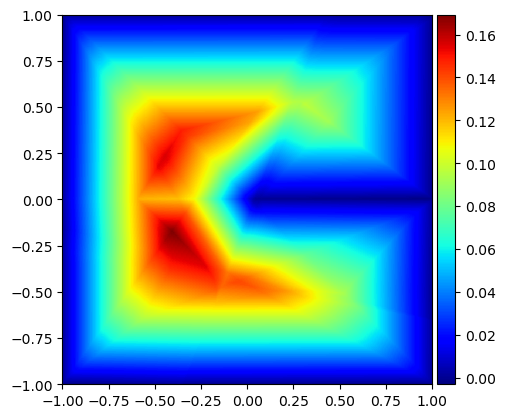

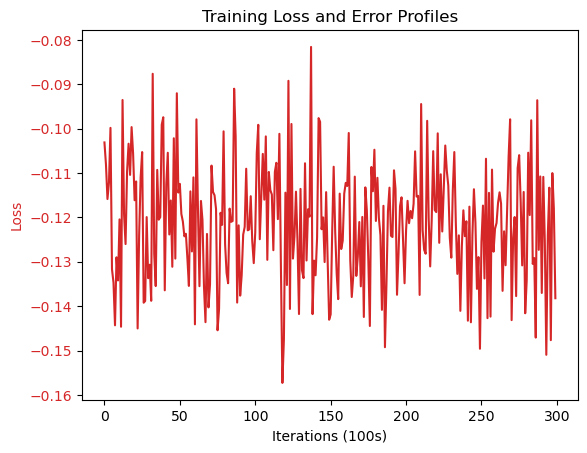

In [33]:
main_original(domain='original', arch='srnn_ReLU', epochs=30000, pretrain=1)

### Standard/Original Architecture, ReLU Activation

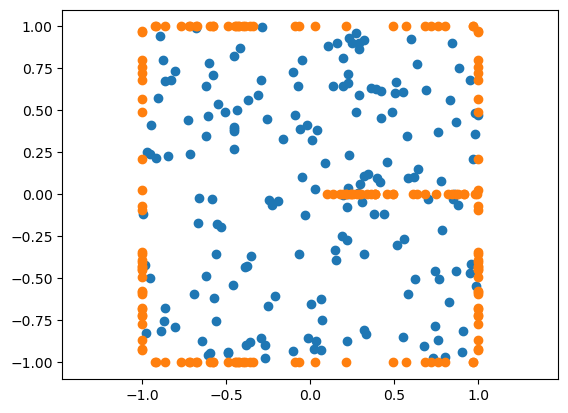

drrnn_ReLU


IntProgress(value=0, max=300)

epoch: 0 loss: 375.53131103515625 loss_r: 0.33891257643699646 loss_b: 375.1924133300781
epoch: 100 loss: 0.0054312050342559814 loss_r: -0.009473816491663456 loss_b: 0.014905021525919437
epoch: 200 loss: -0.022131772711873055 loss_r: -0.025154415518045425 loss_b: 0.0030226432718336582
epoch: 300 loss: -0.0171055905520916 loss_r: -0.05042693018913269 loss_b: 0.03332133963704109
epoch: 400 loss: -0.06090617924928665 loss_r: -0.06500913202762604 loss_b: 0.004102950915694237
epoch: 500 loss: -0.01816241815686226 loss_r: -0.07619191706180573 loss_b: 0.058029498904943466
epoch: 600 loss: -0.05515631288290024 loss_r: -0.0775899887084961 loss_b: 0.022433673962950706
epoch: 700 loss: -0.08230685442686081 loss_r: -0.0851362869143486 loss_b: 0.002829428995028138
epoch: 800 loss: -0.06164795160293579 loss_r: -0.0898323506116867 loss_b: 0.028184400871396065
epoch: 900 loss: -0.11332546919584274 loss_r: -0.12378289550542831 loss_b: 0.010457426309585571
epoch: 1000 loss: -0.09000149369239807 loss_r: -

epoch: 8600 loss: -0.10865557193756104 loss_r: -0.12237538397312164 loss_b: 0.01371980831027031
epoch: 8700 loss: -0.09654096513986588 loss_r: -0.10489612072706223 loss_b: 0.008355152793228626
epoch: 8800 loss: -0.11266603320837021 loss_r: -0.12026209384202957 loss_b: 0.007596062030643225
epoch: 8900 loss: -0.11303049325942993 loss_r: -0.1236250177025795 loss_b: 0.010594521649181843
epoch: 9000 loss: -0.03575471043586731 loss_r: -0.1312226951122284 loss_b: 0.09546798467636108
epoch: 9100 loss: -0.12066635489463806 loss_r: -0.13681671023368835 loss_b: 0.016150351613759995
epoch: 9200 loss: -0.08507712930440903 loss_r: -0.12230786681175232 loss_b: 0.03723073750734329
epoch: 9300 loss: -0.07537059485912323 loss_r: -0.10534064471721649 loss_b: 0.02997005172073841
epoch: 9400 loss: -0.11292967200279236 loss_r: -0.1466194987297058 loss_b: 0.03368982672691345
epoch: 9500 loss: -0.10163287818431854 loss_r: -0.1471511870622635 loss_b: 0.045518308877944946
epoch: 9600 loss: -0.12261610478162766 

epoch: 17100 loss: -0.11308321356773376 loss_r: -0.12185850739479065 loss_b: 0.008775291964411736
epoch: 17200 loss: -0.09750230610370636 loss_r: -0.11915178596973419 loss_b: 0.02164948172867298
epoch: 17300 loss: -0.13769717514514923 loss_r: -0.1503051221370697 loss_b: 0.012607946060597897
epoch: 17400 loss: -0.11057819426059723 loss_r: -0.13043799996376038 loss_b: 0.01985980197787285
epoch: 17500 loss: -0.0851074755191803 loss_r: -0.10420640558004379 loss_b: 0.019098926335573196
epoch: 17600 loss: -0.11190038174390793 loss_r: -0.12455864250659943 loss_b: 0.012658261694014072
epoch: 17700 loss: -0.10115481168031693 loss_r: -0.10232794284820557 loss_b: 0.0011731277918443084
epoch: 17800 loss: -0.09960228949785233 loss_r: -0.10459329932928085 loss_b: 0.004991011694073677
epoch: 17900 loss: -0.12694033980369568 loss_r: -0.1315556913614273 loss_b: 0.004615345969796181
epoch: 18000 loss: -0.10958153009414673 loss_r: -0.12067998945713043 loss_b: 0.011098459362983704
epoch: 18100 loss: -0.09

epoch: 25600 loss: -0.12006564438343048 loss_r: -0.12491260468959808 loss_b: 0.004846961237490177
epoch: 25700 loss: -0.09905754029750824 loss_r: -0.120195172727108 loss_b: 0.02113763615489006
epoch: 25800 loss: -0.11814279109239578 loss_r: -0.11990953981876373 loss_b: 0.0017667504725977778
epoch: 25900 loss: -0.12647001445293427 loss_r: -0.12788456678390503 loss_b: 0.0014145525638014078
epoch: 26000 loss: -0.12592029571533203 loss_r: -0.13289202749729156 loss_b: 0.006971724797040224
epoch: 26100 loss: -0.1307467222213745 loss_r: -0.14241978526115417 loss_b: 0.01167306862771511
epoch: 26200 loss: -0.12965352833271027 loss_r: -0.1339661031961441 loss_b: 0.004312570206820965
epoch: 26300 loss: -0.12438210844993591 loss_r: -0.1417662799358368 loss_b: 0.017384173348546028
epoch: 26400 loss: -0.10559549927711487 loss_r: -0.10798285901546478 loss_b: 0.00238736136816442
epoch: 26500 loss: -0.13214097917079926 loss_r: -0.14427636563777924 loss_b: 0.012135383673012257
epoch: 26600 loss: -0.1037

/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


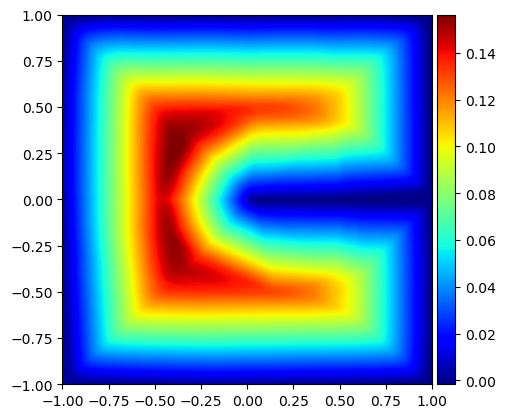

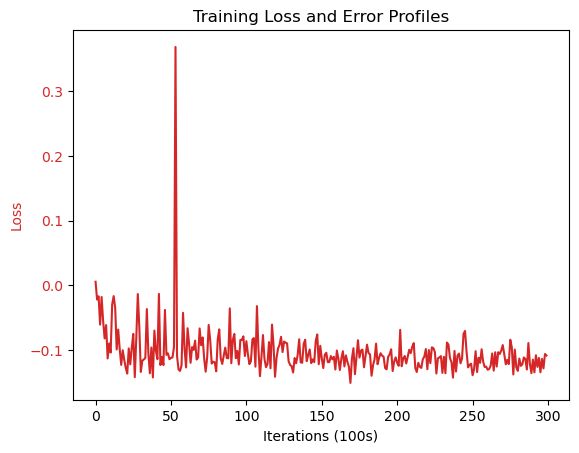

In [20]:
main_original(domain='original', arch='drrnn_ReLU', epochs=30000, save=0, m=100)

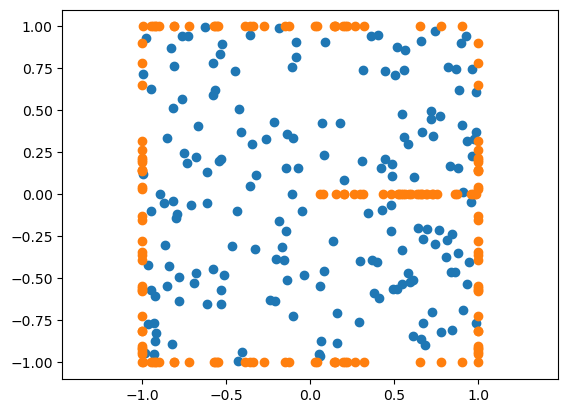

drrnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 8002.5029296875 loss_r: 9.042415618896484 loss_b: 7993.46044921875
epoch: 100 loss: 1.3358384370803833 loss_r: -0.03949478641152382 loss_b: 1.3753331899642944
epoch: 200 loss: 0.21919633448123932 loss_r: -0.03021659329533577 loss_b: 0.2494129240512848
epoch: 300 loss: 0.1640026867389679 loss_r: 0.02013492025434971 loss_b: 0.14386776089668274
epoch: 400 loss: 0.06575927883386612 loss_r: -0.027412818744778633 loss_b: 0.0931720957159996
epoch: 500 loss: 0.03306899964809418 loss_r: -0.04913213104009628 loss_b: 0.08220113068819046
epoch: 600 loss: 0.01229158416390419 loss_r: -0.046947408467531204 loss_b: 0.059238992631435394
epoch: 700 loss: -0.003620389848947525 loss_r: -0.03502119705080986 loss_b: 0.031400807201862335
epoch: 800 loss: -0.01598689705133438 loss_r: -0.053345851600170135 loss_b: 0.037358954548835754
epoch: 900 loss: -0.0008385181427001953 loss_r: -0.035736434161663055 loss_b: 0.03489791601896286
epoch: 1000 loss: -0.005449600517749786 loss_r: -0.03514122590422

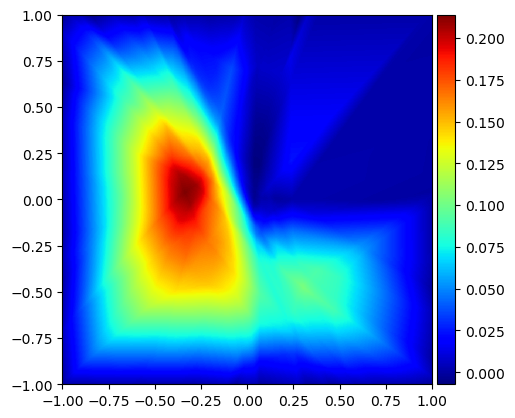

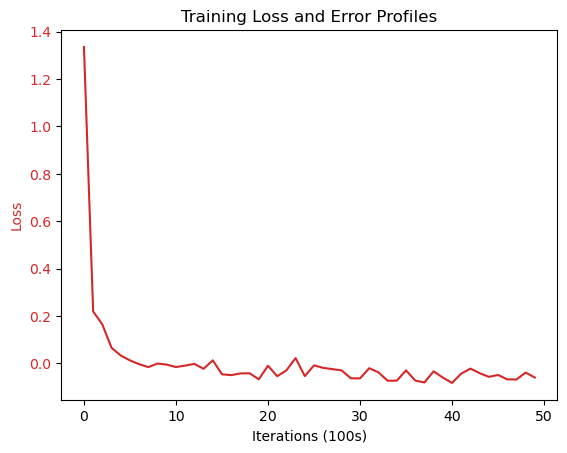

In [28]:
main_original(domain='original', arch='drrnn_ReLU', epochs=5000, pretrain=2)

drrnn_ReLU


IntProgress(value=0, max=250)

epoch: 0 loss: -0.03874621540307999 loss_r: -0.06635495275259018 loss_b: 0.027608739212155342
epoch: 100 loss: -0.012154394760727882 loss_r: -0.04123825207352638 loss_b: 0.0290838573127985
epoch: 200 loss: -0.03804219886660576 loss_r: -0.055645935237407684 loss_b: 0.017603736370801926
epoch: 300 loss: -0.046264514327049255 loss_r: -0.06121724098920822 loss_b: 0.014952728524804115
epoch: 400 loss: -0.02791561558842659 loss_r: -0.04351646080613136 loss_b: 0.015600844286382198
epoch: 500 loss: -0.034670840948820114 loss_r: -0.0500364787876606 loss_b: 0.01536563877016306
epoch: 600 loss: -0.07245282083749771 loss_r: -0.07842039316892624 loss_b: 0.0059675718657672405
epoch: 700 loss: -0.03947018086910248 loss_r: -0.045221958309412 loss_b: 0.005751778371632099
epoch: 800 loss: -0.03393569588661194 loss_r: -0.038987405598163605 loss_b: 0.005051708314567804
epoch: 900 loss: -0.055334169417619705 loss_r: -0.06312648952007294 loss_b: 0.007792321499437094
epoch: 1000 loss: -0.05514863133430481 lo

epoch: 8600 loss: -0.1194978803396225 loss_r: -0.130670964717865 loss_b: 0.011173086240887642
epoch: 8700 loss: -0.09613200277090073 loss_r: -0.11142594367265701 loss_b: 0.015293941833078861
epoch: 8800 loss: -0.13249388337135315 loss_r: -0.1406736969947815 loss_b: 0.008179816417396069
epoch: 8900 loss: -0.11792129278182983 loss_r: -0.12583886086940765 loss_b: 0.007917570881545544
epoch: 9000 loss: -0.09744478017091751 loss_r: -0.15205280482769012 loss_b: 0.054608024656772614
epoch: 9100 loss: -0.07428858429193497 loss_r: -0.13555283844470978 loss_b: 0.06126425415277481
epoch: 9200 loss: -0.09398633241653442 loss_r: -0.13858163356781006 loss_b: 0.044595301151275635
epoch: 9300 loss: -0.1301950216293335 loss_r: -0.13857443630695343 loss_b: 0.00837941188365221
epoch: 9400 loss: -0.11436459422111511 loss_r: -0.16147609055042267 loss_b: 0.047111500054597855
epoch: 9500 loss: -0.11080765724182129 loss_r: -0.1287223845720291 loss_b: 0.017914725467562675
epoch: 9600 loss: -0.10660344362258911

epoch: 17100 loss: -0.08510772138834 loss_r: -0.10660839080810547 loss_b: 0.021500667557120323
epoch: 17200 loss: -0.12909281253814697 loss_r: -0.1403094232082367 loss_b: 0.011216618120670319
epoch: 17300 loss: -0.11454279720783234 loss_r: -0.14245186746120453 loss_b: 0.027909068390727043
epoch: 17400 loss: -0.12446124106645584 loss_r: -0.13322636485099792 loss_b: 0.008765121921896935
epoch: 17500 loss: -0.13429990410804749 loss_r: -0.15294595062732697 loss_b: 0.018646040931344032
epoch: 17600 loss: -0.14641058444976807 loss_r: -0.1510528028011322 loss_b: 0.004642218351364136
epoch: 17700 loss: -0.12028791010379791 loss_r: -0.13032473623752594 loss_b: 0.010036824271082878
epoch: 17800 loss: -0.09745034575462341 loss_r: -0.11256741732358932 loss_b: 0.015117070637643337
epoch: 17900 loss: -0.1140320897102356 loss_r: -0.12459045648574829 loss_b: 0.010558364912867546
epoch: 18000 loss: -0.11401306092739105 loss_r: -0.12692026793956757 loss_b: 0.012907207943499088
epoch: 18100 loss: -0.1272

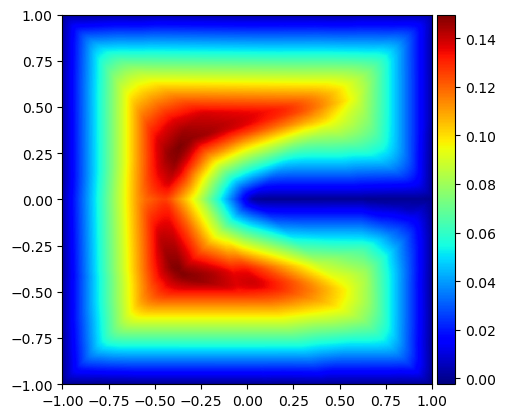

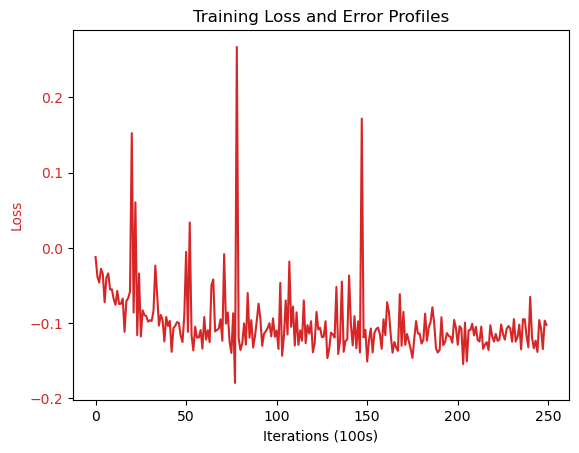

In [29]:
main_original(domain='original', arch='drrnn_ReLU', epochs=25000, pretrain=1)

drrnn_ReLU


IntProgress(value=0, max=300)

epoch: 0 loss: -0.10627500712871552 loss_r: -0.1186516061425209 loss_b: 0.012376596219837666
epoch: 100 loss: -0.11435416340827942 loss_r: -0.11736584454774857 loss_b: 0.003011679509654641
epoch: 200 loss: -0.12815675139427185 loss_r: -0.13226185739040375 loss_b: 0.004105112049728632
epoch: 300 loss: -0.11835136264562607 loss_r: -0.12198122590780258 loss_b: 0.0036298648919910192
epoch: 400 loss: -0.11452095210552216 loss_r: -0.11751614511013031 loss_b: 0.0029951923061162233
epoch: 500 loss: -0.14619746804237366 loss_r: -0.14924553036689758 loss_b: 0.0030480604618787766
epoch: 600 loss: -0.16154609620571136 loss_r: -0.163787841796875 loss_b: 0.0022417528089135885
epoch: 700 loss: -0.12944062054157257 loss_r: -0.1320941299200058 loss_b: 0.0026535054203122854
epoch: 800 loss: -0.15719380974769592 loss_r: -0.1623561680316925 loss_b: 0.00516236387193203
epoch: 900 loss: -0.11614278703927994 loss_r: -0.1277775764465332 loss_b: 0.01163479033857584
epoch: 1000 loss: -0.13497374951839447 loss_r

epoch: 8500 loss: -0.10891424119472504 loss_r: -0.14370113611221313 loss_b: 0.0347868949174881
epoch: 8600 loss: -0.11455880850553513 loss_r: -0.11756694316864014 loss_b: 0.003008131170645356
epoch: 8700 loss: -0.12364178150892258 loss_r: -0.12579619884490967 loss_b: 0.0021544205956161022
epoch: 8800 loss: -0.11950863897800446 loss_r: -0.12361861020326614 loss_b: 0.004109970759600401
epoch: 8900 loss: -0.1132432073354721 loss_r: -0.12285663187503815 loss_b: 0.009613428264856339
epoch: 9000 loss: -0.1272563487291336 loss_r: -0.13142061233520508 loss_b: 0.00416426220908761
epoch: 9100 loss: -0.11438117176294327 loss_r: -0.13221928477287292 loss_b: 0.017838113009929657
epoch: 9200 loss: -0.11549066752195358 loss_r: -0.11998037993907928 loss_b: 0.0044897133484482765
epoch: 9300 loss: -0.12721510231494904 loss_r: -0.13430805504322052 loss_b: 0.0070929499343037605
epoch: 9400 loss: -0.11491978168487549 loss_r: -0.12084831297397614 loss_b: 0.005928529892116785
epoch: 9500 loss: -0.15288621187

epoch: 17000 loss: -0.1496434062719345 loss_r: -0.1537589281797409 loss_b: 0.0041155219078063965
epoch: 17100 loss: -0.14479923248291016 loss_r: -0.1492081731557846 loss_b: 0.004408945329487324
epoch: 17200 loss: -0.12994424998760223 loss_r: -0.14010274410247803 loss_b: 0.010158496908843517
epoch: 17300 loss: -0.11831217259168625 loss_r: -0.12851513922214508 loss_b: 0.010202967561781406
epoch: 17400 loss: -0.09844565391540527 loss_r: -0.11556711047887802 loss_b: 0.017121456563472748
epoch: 17500 loss: -0.11587773263454437 loss_r: -0.12173163890838623 loss_b: 0.005853903014212847
epoch: 17600 loss: -0.11524059623479843 loss_r: -0.12328025698661804 loss_b: 0.008039659820497036
epoch: 17700 loss: -0.15214073657989502 loss_r: -0.15560676157474518 loss_b: 0.003466023365035653
epoch: 17800 loss: -0.10877296328544617 loss_r: -0.1215580552816391 loss_b: 0.012785092927515507
epoch: 17900 loss: -0.11611518263816833 loss_r: -0.12124083191156387 loss_b: 0.0051256525330245495
epoch: 18000 loss: -0.

epoch: 25400 loss: -0.14168056845664978 loss_r: -0.14356671273708344 loss_b: 0.0018861406715586782
epoch: 25500 loss: -0.12734739482402802 loss_r: -0.13494941592216492 loss_b: 0.007602023426443338
epoch: 25600 loss: -0.10234902799129486 loss_r: -0.11884436011314392 loss_b: 0.01649533398449421
epoch: 25700 loss: -0.112747922539711 loss_r: -0.11806502938270569 loss_b: 0.005317104514688253
epoch: 25800 loss: -0.12371319532394409 loss_r: -0.12590114772319794 loss_b: 0.002187952632084489
epoch: 25900 loss: -0.12090764194726944 loss_r: -0.12981848418712616 loss_b: 0.00891084410250187
epoch: 26000 loss: -0.11625230312347412 loss_r: -0.12631748616695404 loss_b: 0.010065185837447643
epoch: 26100 loss: -0.09322284162044525 loss_r: -0.12164965271949768 loss_b: 0.02842681109905243
epoch: 26200 loss: -0.14775989949703217 loss_r: -0.15070194005966187 loss_b: 0.0029420359060168266
epoch: 26300 loss: -0.09596605598926544 loss_r: -0.12646429240703583 loss_b: 0.030498232692480087
epoch: 26400 loss: -0.1

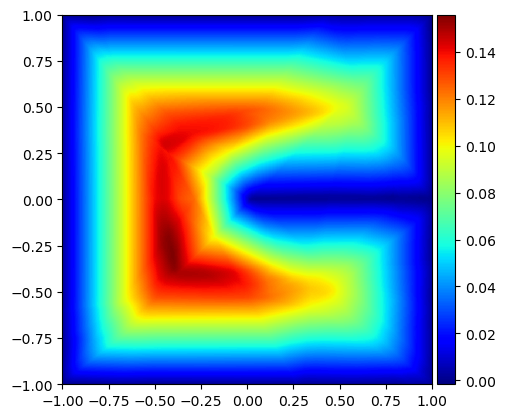

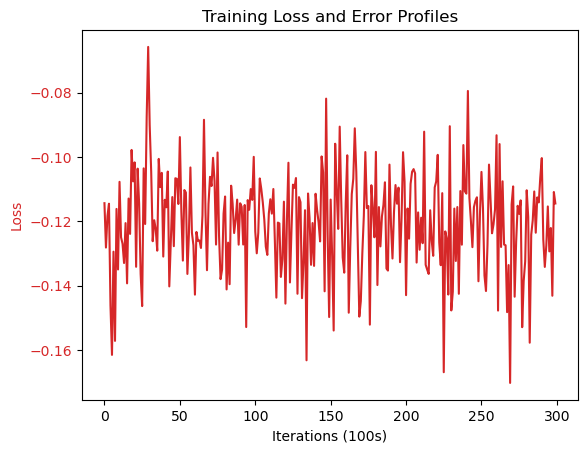

In [30]:
main_original(domain='original', arch='drrnn_ReLU', epochs=30000, pretrain=1)

### Standard/Original Architecture, Tanh Activation

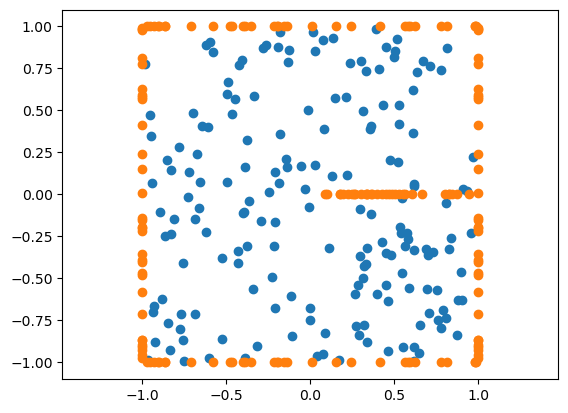

drrnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 41992.27734375 loss_r: 41.89006423950195 loss_b: 41950.38671875
epoch: 100 loss: 10.399495124816895 loss_r: 1.4972727298736572 loss_b: 8.902222633361816
epoch: 200 loss: 5.425096035003662 loss_r: 0.8297271132469177 loss_b: 4.5953688621521
epoch: 300 loss: 3.8693411350250244 loss_r: 0.7992033362388611 loss_b: 3.0701377391815186
epoch: 400 loss: 2.9419775009155273 loss_r: 0.5585562586784363 loss_b: 2.3834211826324463
epoch: 500 loss: 2.348515033721924 loss_r: 0.5894168019294739 loss_b: 1.7590981721878052
epoch: 600 loss: 1.9307324886322021 loss_r: 0.6188772320747375 loss_b: 1.3118553161621094
epoch: 700 loss: 1.3837586641311646 loss_r: 0.4059176445007324 loss_b: 0.9778410196304321
epoch: 800 loss: 1.2179572582244873 loss_r: 0.3933228850364685 loss_b: 0.824634313583374
epoch: 900 loss: 0.9246746301651001 loss_r: 0.34485480189323425 loss_b: 0.5798198580741882
epoch: 1000 loss: 0.8535678386688232 loss_r: 0.3757408857345581 loss_b: 0.47782695293426514
epoch: 1100 loss: 0.68275

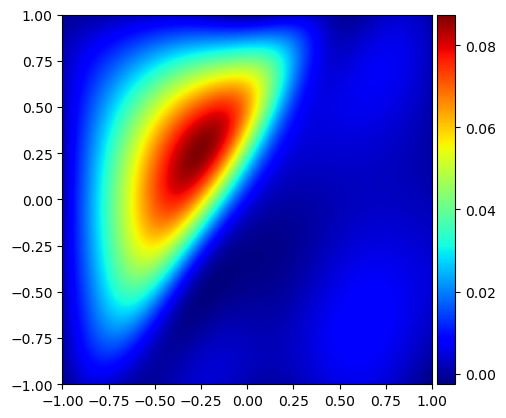

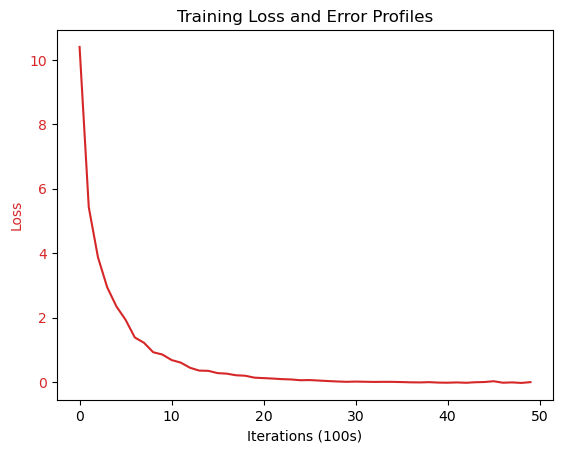

In [19]:
main_original(domain='original', arch='drrnn_Tanh', epochs=5000, pretrain=2)

drrnn_Tanh


IntProgress(value=0, max=250)

epoch: 0 loss: -0.023434951901435852 loss_r: -0.04666203632950783 loss_b: 0.023227084428071976
epoch: 100 loss: 0.030817992985248566 loss_r: -0.026797428727149963 loss_b: 0.05761542171239853
epoch: 200 loss: -0.009104825556278229 loss_r: -0.027217362076044083 loss_b: 0.018112536519765854
epoch: 300 loss: -0.01496108528226614 loss_r: -0.025794701650738716 loss_b: 0.010833616368472576
epoch: 400 loss: -0.006258394569158554 loss_r: -0.01732633076608181 loss_b: 0.011067936196923256
epoch: 500 loss: -0.007390920072793961 loss_r: -0.03391561284661293 loss_b: 0.02652469277381897
epoch: 600 loss: -0.015347582288086414 loss_r: -0.026679983362555504 loss_b: 0.01133240107446909
epoch: 700 loss: -0.017648564651608467 loss_r: -0.029881075024604797 loss_b: 0.01223251037299633
epoch: 800 loss: -0.030395478010177612 loss_r: -0.04349292814731598 loss_b: 0.013097450137138367
epoch: 900 loss: -0.031365495175123215 loss_r: -0.04284071922302246 loss_b: 0.011475224047899246
epoch: 1000 loss: -0.031958803534

epoch: 8600 loss: -0.08104696869850159 loss_r: -0.09649239480495453 loss_b: 0.015445422381162643
epoch: 8700 loss: 0.0698806568980217 loss_r: -0.08764829486608505 loss_b: 0.15752895176410675
epoch: 8800 loss: -0.07479024678468704 loss_r: -0.09729510545730591 loss_b: 0.022504856809973717
epoch: 8900 loss: -0.023312702775001526 loss_r: -0.10587240010499954 loss_b: 0.08255969732999802
epoch: 9000 loss: -0.04649089276790619 loss_r: -0.11314357817173004 loss_b: 0.06665268540382385
epoch: 9100 loss: -0.07354125380516052 loss_r: -0.10432080179452896 loss_b: 0.03077954426407814
epoch: 9200 loss: -0.08969175815582275 loss_r: -0.10450898110866547 loss_b: 0.014817223884165287
epoch: 9300 loss: -0.07281164824962616 loss_r: -0.13282617926597595 loss_b: 0.06001453474164009
epoch: 9400 loss: -0.06804793328046799 loss_r: -0.12040705233812332 loss_b: 0.052359119057655334
epoch: 9500 loss: -0.05533953011035919 loss_r: -0.1056685596704483 loss_b: 0.05032902956008911
epoch: 9600 loss: -0.02582561224699020

epoch: 17100 loss: -0.12687289714813232 loss_r: -0.13786634802818298 loss_b: 0.010993448086082935
epoch: 17200 loss: -0.088050477206707 loss_r: -0.11892212927341461 loss_b: 0.030871650204062462
epoch: 17300 loss: -0.11800016462802887 loss_r: -0.1246149092912674 loss_b: 0.006614745128899813
epoch: 17400 loss: -0.11595706641674042 loss_r: -0.1295156031847 loss_b: 0.013558534905314445
epoch: 17500 loss: -0.08771486580371857 loss_r: -0.12492769956588745 loss_b: 0.03721283748745918
epoch: 17600 loss: -0.10133742541074753 loss_r: -0.12152411788702011 loss_b: 0.020186690613627434
epoch: 17700 loss: 0.018869519233703613 loss_r: -0.14549162983894348 loss_b: 0.1643611490726471
epoch: 17800 loss: -0.06358019262552261 loss_r: -0.1279853880405426 loss_b: 0.06440519541501999
epoch: 17900 loss: -0.10320529341697693 loss_r: -0.14350344240665436 loss_b: 0.04029815271496773
epoch: 18000 loss: -0.08631163835525513 loss_r: -0.12907624244689941 loss_b: 0.04276460409164429
epoch: 18100 loss: -0.091891720890

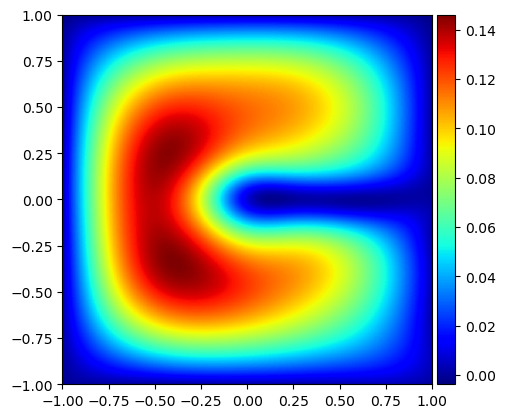

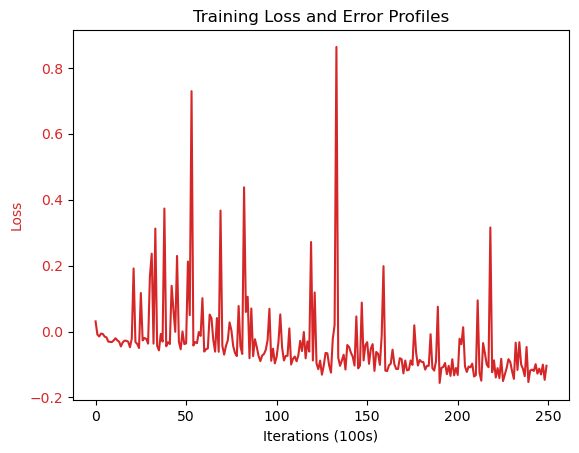

In [20]:
main_original(domain='original', arch='drrnn_Tanh', epochs=25000, pretrain=1)

drrnn_Tanh


IntProgress(value=0, max=300)

epoch: 0 loss: -0.14431779086589813 loss_r: -0.15966226160526276 loss_b: 0.015344467014074326
epoch: 100 loss: -0.09475729614496231 loss_r: -0.10461422055959702 loss_b: 0.00985692348331213
epoch: 200 loss: -0.11099419742822647 loss_r: -0.11809974163770676 loss_b: 0.007105545606464148
epoch: 300 loss: -0.12119117379188538 loss_r: -0.12536494433879852 loss_b: 0.0041737668216228485
epoch: 400 loss: -0.11177028715610504 loss_r: -0.11813831329345703 loss_b: 0.006368023343384266
epoch: 500 loss: -0.11691904067993164 loss_r: -0.12241872400045395 loss_b: 0.005499685183167458
epoch: 600 loss: -0.1474139541387558 loss_r: -0.1548498570919037 loss_b: 0.007435904815793037
epoch: 700 loss: -0.13147853314876556 loss_r: -0.140645369887352 loss_b: 0.009166831150650978
epoch: 800 loss: -0.14569397270679474 loss_r: -0.15225626528263092 loss_b: 0.006562298629432917
epoch: 900 loss: -0.13287889957427979 loss_r: -0.14984671771526337 loss_b: 0.01696782186627388
epoch: 1000 loss: -0.13872918486595154 loss_r: 

epoch: 8600 loss: -0.1221381425857544 loss_r: -0.14952214062213898 loss_b: 0.027383994311094284
epoch: 8700 loss: -0.08075278252363205 loss_r: -0.15157021582126617 loss_b: 0.07081743329763412
epoch: 8800 loss: -0.11829736828804016 loss_r: -0.13413572311401367 loss_b: 0.01583835296332836
epoch: 8900 loss: -0.11202456802129745 loss_r: -0.12703780829906464 loss_b: 0.015013237483799458
epoch: 9000 loss: -0.12814348936080933 loss_r: -0.15629753470420837 loss_b: 0.028154049068689346
epoch: 9100 loss: -0.14793115854263306 loss_r: -0.15770210325717926 loss_b: 0.009770946577191353
epoch: 9200 loss: -0.1388528048992157 loss_r: -0.15447229146957397 loss_b: 0.015619481913745403
epoch: 9300 loss: -0.1304360330104828 loss_r: -0.17174924910068512 loss_b: 0.04131321236491203
epoch: 9400 loss: -0.13810569047927856 loss_r: -0.15613305568695068 loss_b: 0.01802736148238182
epoch: 9500 loss: -0.09855054318904877 loss_r: -0.1300572007894516 loss_b: 0.03150665760040283
epoch: 9600 loss: -0.15299810469150543 

epoch: 17100 loss: -0.1507798433303833 loss_r: -0.17850609123706818 loss_b: 0.027726255357265472
epoch: 17200 loss: -0.16260938346385956 loss_r: -0.17510727047920227 loss_b: 0.012497888877987862
epoch: 17300 loss: -0.09715604782104492 loss_r: -0.11284171789884567 loss_b: 0.01568567007780075
epoch: 17400 loss: -0.10978474467992783 loss_r: -0.13603083789348602 loss_b: 0.026246091350913048
epoch: 17500 loss: -0.11845351755619049 loss_r: -0.13729995489120483 loss_b: 0.01884644106030464
epoch: 17600 loss: -0.1420336663722992 loss_r: -0.14727260172367096 loss_b: 0.005238937679678202
epoch: 17700 loss: -0.18839479982852936 loss_r: -0.19916272163391113 loss_b: 0.010767924599349499
epoch: 17800 loss: -0.15793386101722717 loss_r: -0.17029374837875366 loss_b: 0.01235988549888134
epoch: 17900 loss: -0.1778939813375473 loss_r: -0.19102269411087036 loss_b: 0.013128712773323059
epoch: 18000 loss: -0.14296060800552368 loss_r: -0.15922541916370392 loss_b: 0.01626480743288994
epoch: 18100 loss: -0.11926

epoch: 25600 loss: -0.1394023299217224 loss_r: -0.14964750409126282 loss_b: 0.01024517323821783
epoch: 25700 loss: -0.1097375750541687 loss_r: -0.14241524040699005 loss_b: 0.03267766907811165
epoch: 25800 loss: -0.16404949128627777 loss_r: -0.17870774865150452 loss_b: 0.014658251777291298
epoch: 25900 loss: -0.1524311900138855 loss_r: -0.15776929259300232 loss_b: 0.0053380983881652355
epoch: 26000 loss: -0.10678514838218689 loss_r: -0.11854174733161926 loss_b: 0.011756595224142075
epoch: 26100 loss: -0.1430208832025528 loss_r: -0.14789357781410217 loss_b: 0.004872698336839676
epoch: 26200 loss: -0.15775799751281738 loss_r: -0.17173077166080475 loss_b: 0.013972779735922813
epoch: 26300 loss: -0.10400193929672241 loss_r: -0.11506129056215286 loss_b: 0.011059352196753025
epoch: 26400 loss: -0.11486977338790894 loss_r: -0.13649021089076996 loss_b: 0.021620437502861023
epoch: 26500 loss: -0.14524617791175842 loss_r: -0.15234355628490448 loss_b: 0.00709737092256546
epoch: 26600 loss: -0.1089

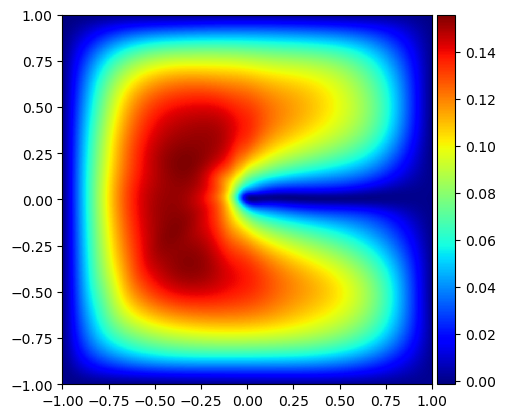

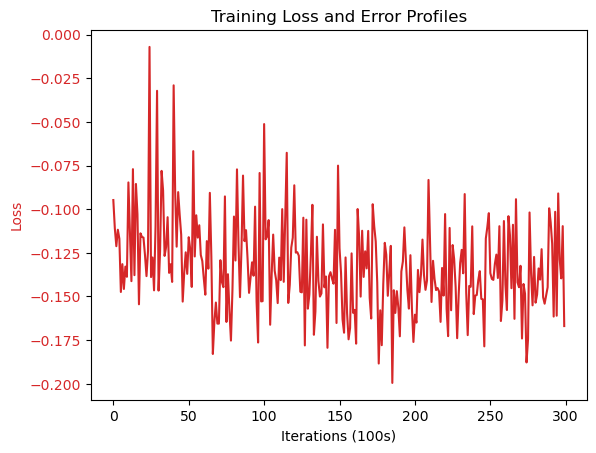

In [21]:
main_original(domain='original', arch='drrnn_Tanh', epochs=30000, pretrain=1)

drrnn_Tanh


IntProgress(value=0, max=300)

epoch: 0 loss: -0.1497693657875061 loss_r: -0.15261729061603546 loss_b: 0.002847927389666438
epoch: 100 loss: -0.12378382682800293 loss_r: -0.13119347393512726 loss_b: 0.007409646175801754
epoch: 200 loss: -0.12659572064876556 loss_r: -0.13042274117469788 loss_b: 0.0038270270451903343
epoch: 300 loss: -0.19418154656887054 loss_r: -0.19847659766674042 loss_b: 0.004295052960515022
epoch: 400 loss: -0.2035837173461914 loss_r: -0.20954716205596924 loss_b: 0.005963441915810108
epoch: 500 loss: -0.151889830827713 loss_r: -0.16344483196735382 loss_b: 0.01155499741435051
epoch: 600 loss: -0.15107840299606323 loss_r: -0.15491029620170593 loss_b: 0.003831893438473344
epoch: 700 loss: -0.11914704740047455 loss_r: -0.12232179194688797 loss_b: 0.003174742218106985
epoch: 800 loss: -0.15716180205345154 loss_r: -0.16051293909549713 loss_b: 0.00335113937035203
epoch: 900 loss: -0.1455417275428772 loss_r: -0.15396861732006073 loss_b: 0.008426891639828682
epoch: 1000 loss: -0.192092627286911 loss_r: -0.

epoch: 8500 loss: -0.18631771206855774 loss_r: -0.196241557598114 loss_b: 0.00992384273558855
epoch: 8600 loss: -0.17799969017505646 loss_r: -0.19592954218387604 loss_b: 0.017929857596755028
epoch: 8700 loss: -0.13383327424526215 loss_r: -0.14541520178318024 loss_b: 0.011581932194530964
epoch: 8800 loss: -0.15750542283058167 loss_r: -0.1646713763475418 loss_b: 0.007165947463363409
epoch: 8900 loss: -0.12190423160791397 loss_r: -0.1293855607509613 loss_b: 0.007481331471353769
epoch: 9000 loss: -0.1514708548784256 loss_r: -0.15769773721694946 loss_b: 0.006226883269846439
epoch: 9100 loss: -0.1529097706079483 loss_r: -0.16852222383022308 loss_b: 0.015612454153597355
epoch: 9200 loss: -0.1649021953344345 loss_r: -0.169627845287323 loss_b: 0.004725646693259478
epoch: 9300 loss: -0.16074225306510925 loss_r: -0.1684965193271637 loss_b: 0.007754271384328604
epoch: 9400 loss: -0.14528042078018188 loss_r: -0.1493983417749405 loss_b: 0.004117928445339203
epoch: 9500 loss: -0.18529748916625977 los

epoch: 17000 loss: -0.11156339943408966 loss_r: -0.12788553535938263 loss_b: 0.01632213592529297
epoch: 17100 loss: -0.1594841480255127 loss_r: -0.16607891023159027 loss_b: 0.0065947650000452995
epoch: 17200 loss: -0.11979515105485916 loss_r: -0.13234220445156097 loss_b: 0.012547052465379238
epoch: 17300 loss: -0.1324617862701416 loss_r: -0.14913932979106903 loss_b: 0.016677550971508026
epoch: 17400 loss: -0.11692562699317932 loss_r: -0.11965484917163849 loss_b: 0.002729225205257535
epoch: 17500 loss: -0.14715301990509033 loss_r: -0.15199483931064606 loss_b: 0.004841821733862162
epoch: 17600 loss: -0.15426266193389893 loss_r: -0.15858502686023712 loss_b: 0.0043223705142736435
epoch: 17700 loss: -0.17333637177944183 loss_r: -0.18382634222507477 loss_b: 0.010489963926374912
epoch: 17800 loss: -0.14444218575954437 loss_r: -0.14632253348827362 loss_b: 0.0018803485436365008
epoch: 17900 loss: -0.1686868518590927 loss_r: -0.17345930635929108 loss_b: 0.004772447515279055
epoch: 18000 loss: -0

epoch: 25400 loss: -0.1602945327758789 loss_r: -0.16732174158096313 loss_b: 0.007027209270745516
epoch: 25500 loss: -0.17035731673240662 loss_r: -0.17871172726154327 loss_b: 0.008354409597814083
epoch: 25600 loss: -0.14810596406459808 loss_r: -0.15531717240810394 loss_b: 0.007211212534457445
epoch: 25700 loss: -0.1576719880104065 loss_r: -0.16798335313796997 loss_b: 0.010311361402273178
epoch: 25800 loss: -0.14392027258872986 loss_r: -0.14962360262870789 loss_b: 0.005703326780349016
epoch: 25900 loss: -0.1319674402475357 loss_r: -0.14224280416965485 loss_b: 0.010275369510054588
epoch: 26000 loss: -0.15095657110214233 loss_r: -0.1546318233013153 loss_b: 0.003675255225971341
epoch: 26100 loss: -0.20678307116031647 loss_r: -0.2091618776321411 loss_b: 0.00237881182692945
epoch: 26200 loss: -0.14250364899635315 loss_r: -0.15289707481861115 loss_b: 0.01039342675358057
epoch: 26300 loss: -0.16480298340320587 loss_r: -0.1766015589237213 loss_b: 0.01179856900125742
epoch: 26400 loss: -0.1740173

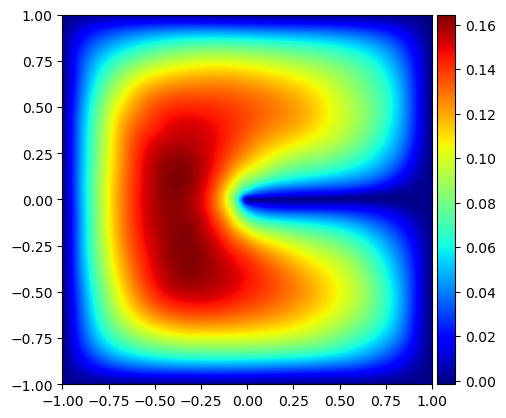

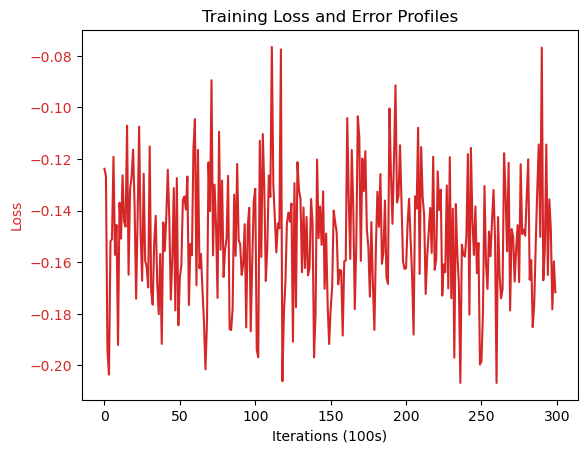

In [34]:
main_original(domain='original', arch='drrnn_Tanh', epochs=30000, pretrain=1)

### Feedforward NN, ReLU Activation

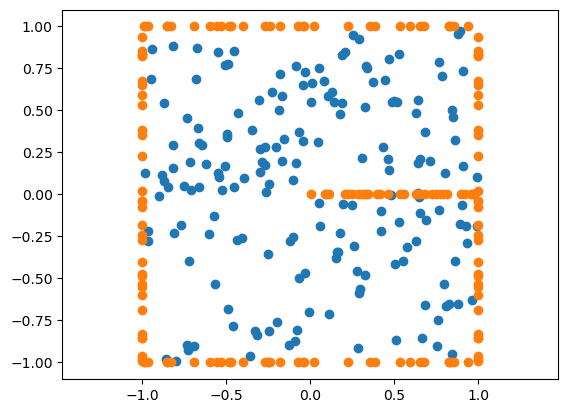

drfnn_ReLU


IntProgress(value=0, max=50)

epoch: 0 loss: 0.01715121977031231 loss_r: -0.006125081330537796 loss_b: 0.023276301100850105
epoch: 100 loss: -0.003610929474234581 loss_r: -0.007507340516895056 loss_b: 0.0038964110426604748
epoch: 200 loss: -0.06914964318275452 loss_r: -0.07290247082710266 loss_b: 0.003752828110009432
epoch: 300 loss: -0.10322223603725433 loss_r: -0.10611175000667572 loss_b: 0.002889511873945594
epoch: 400 loss: -0.11439231783151627 loss_r: -0.1317228078842163 loss_b: 0.017330491915345192
epoch: 500 loss: -0.08705101907253265 loss_r: -0.0915306881070137 loss_b: 0.004479671828448772
epoch: 600 loss: -0.10828744620084763 loss_r: -0.10860459506511688 loss_b: 0.0003171510761603713
epoch: 700 loss: -0.1309228092432022 loss_r: -0.13437746465206146 loss_b: 0.0034546598326414824
epoch: 800 loss: -0.11955364048480988 loss_r: -0.1375901848077774 loss_b: 0.01803654432296753
epoch: 900 loss: -0.1289258599281311 loss_r: -0.1377023160457611 loss_b: 0.008776452392339706
epoch: 1000 loss: -0.10645870119333267 loss_

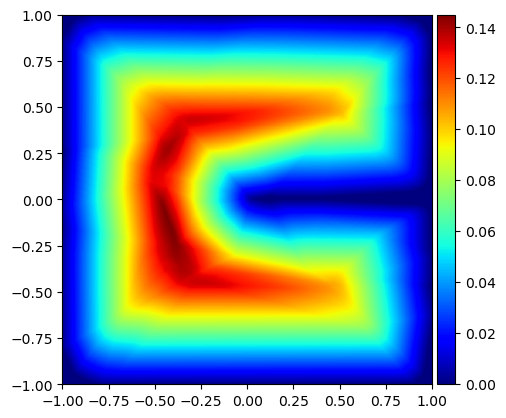

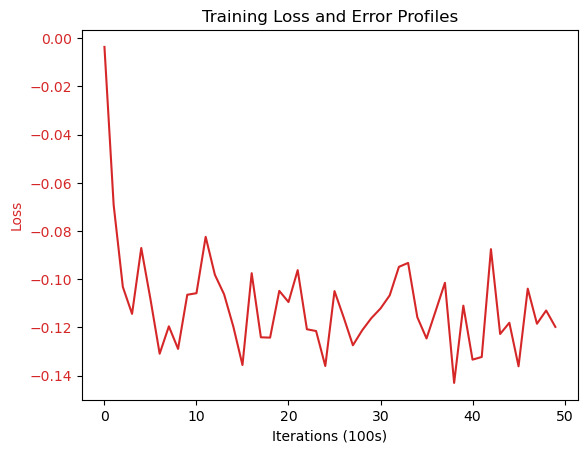

In [25]:
main_original(domain='original', arch='drfnn_ReLU', epochs=5000, pretrain=2)

drfnn_ReLU


IntProgress(value=0, max=250)

epoch: 0 loss: -0.12181226909160614 loss_r: -0.1264084279537201 loss_b: 0.00459615932777524
epoch: 100 loss: -0.11044422537088394 loss_r: -0.1120479479432106 loss_b: 0.0016037252498790622
epoch: 200 loss: -0.10183148086071014 loss_r: -0.10384572297334671 loss_b: 0.002014245605096221
epoch: 300 loss: -0.1255374550819397 loss_r: -0.12857958674430847 loss_b: 0.003042129799723625
epoch: 400 loss: -0.113910011947155 loss_r: -0.14292383193969727 loss_b: 0.029013819992542267
epoch: 500 loss: -0.10640184581279755 loss_r: -0.1094386875629425 loss_b: 0.0030368389561772346
epoch: 600 loss: -0.12065166980028152 loss_r: -0.13492664694786072 loss_b: 0.014274975284934044
epoch: 700 loss: -0.10184048861265182 loss_r: -0.102604940533638 loss_b: 0.0007644511642865837
epoch: 800 loss: -0.14415811002254486 loss_r: -0.14620207250118256 loss_b: 0.002043964108452201
epoch: 900 loss: -0.12865887582302094 loss_r: -0.13287925720214844 loss_b: 0.0042203860357403755
epoch: 1000 loss: -0.10774696618318558 loss_r: 

epoch: 8500 loss: -0.1218569353222847 loss_r: -0.12769216299057007 loss_b: 0.005835225805640221
epoch: 8600 loss: -0.09793725609779358 loss_r: -0.10456164926290512 loss_b: 0.006624392233788967
epoch: 8700 loss: -0.11135762184858322 loss_r: -0.1131298691034317 loss_b: 0.0017722462071105838
epoch: 8800 loss: -0.12430031597614288 loss_r: -0.12537743151187897 loss_b: 0.0010771172819659114
epoch: 8900 loss: -0.134177103638649 loss_r: -0.13746561110019684 loss_b: 0.0032885039690881968
epoch: 9000 loss: -0.13481685519218445 loss_r: -0.13997560739517212 loss_b: 0.005158756393939257
epoch: 9100 loss: -0.12196525931358337 loss_r: -0.12513044476509094 loss_b: 0.0031651833560317755
epoch: 9200 loss: -0.09336201101541519 loss_r: -0.0953548476099968 loss_b: 0.0019928370602428913
epoch: 9300 loss: -0.10618022829294205 loss_r: -0.11384381353855133 loss_b: 0.007663581985980272
epoch: 9400 loss: -0.14086656272411346 loss_r: -0.1448735147714615 loss_b: 0.004006952978670597
epoch: 9500 loss: -0.1222172155

epoch: 16900 loss: -0.11482852697372437 loss_r: -0.11515959352254868 loss_b: 0.0003310652682557702
epoch: 17000 loss: -0.11690514534711838 loss_r: -0.1189548671245575 loss_b: 0.0020497196819633245
epoch: 17100 loss: -0.11473771184682846 loss_r: -0.12983161211013794 loss_b: 0.01509389840066433
epoch: 17200 loss: -0.11477581411600113 loss_r: -0.1174570769071579 loss_b: 0.002681263955309987
epoch: 17300 loss: -0.13255751132965088 loss_r: -0.1337813138961792 loss_b: 0.0012237968621775508
epoch: 17400 loss: -0.12648460268974304 loss_r: -0.12918303906917572 loss_b: 0.002698431257158518
epoch: 17500 loss: -0.1271733194589615 loss_r: -0.1336682289838791 loss_b: 0.006494911853224039
epoch: 17600 loss: -0.11985643953084946 loss_r: -0.126837819814682 loss_b: 0.006981382146477699
epoch: 17700 loss: -0.09515403211116791 loss_r: -0.10012814402580261 loss_b: 0.004974111914634705
epoch: 17800 loss: -0.13333062827587128 loss_r: -0.13445790112018585 loss_b: 0.0011272735428065062
epoch: 17900 loss: -0.13

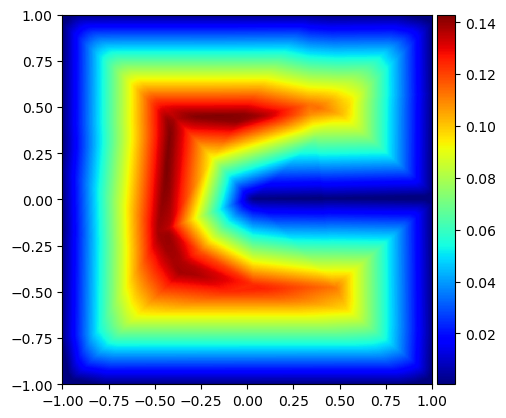

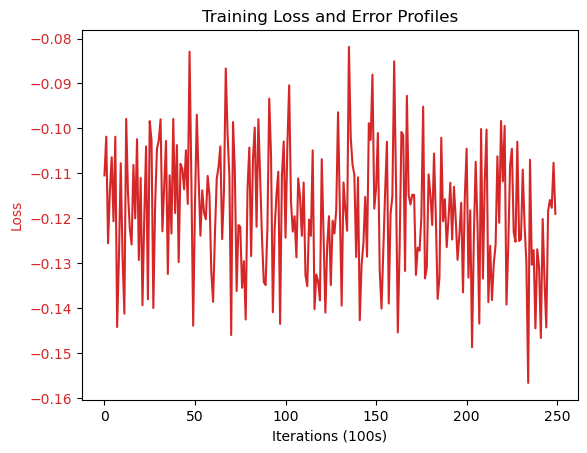

In [26]:
main_original(domain='original', arch='drfnn_ReLU', epochs=25000, pretrain=1)

drfnn_ReLU


IntProgress(value=0, max=300)

epoch: 0 loss: -0.12559811770915985 loss_r: -0.13047659397125244 loss_b: 0.004878481384366751
epoch: 100 loss: -0.111199289560318 loss_r: -0.1113012358546257 loss_b: 0.00010194711649091914
epoch: 200 loss: -0.12747754156589508 loss_r: -0.12838910520076752 loss_b: 0.0009115582797676325
epoch: 300 loss: -0.11376632004976273 loss_r: -0.11951977759599686 loss_b: 0.005753455683588982
epoch: 400 loss: -0.1264963001012802 loss_r: -0.12706358730793 loss_b: 0.0005672942497767508
epoch: 500 loss: -0.12052421271800995 loss_r: -0.12513813376426697 loss_b: 0.004613921511918306
epoch: 600 loss: -0.11635104566812515 loss_r: -0.11952576041221619 loss_b: 0.0031747138127684593
epoch: 700 loss: -0.13061486184597015 loss_r: -0.13522614538669586 loss_b: 0.004611287731677294
epoch: 800 loss: -0.10449516028165817 loss_r: -0.10820553451776505 loss_b: 0.00371037470176816
epoch: 900 loss: -0.0798298791050911 loss_r: -0.09315638244152069 loss_b: 0.01332650613039732
epoch: 1000 loss: -0.11305756121873856 loss_r: 

epoch: 8500 loss: -0.09745921939611435 loss_r: -0.10166725516319275 loss_b: 0.0042080385610461235
epoch: 8600 loss: -0.12475172430276871 loss_r: -0.12566658854484558 loss_b: 0.0009148651733994484
epoch: 8700 loss: -0.11610157787799835 loss_r: -0.11853358894586563 loss_b: 0.0024320129305124283
epoch: 8800 loss: -0.13906416296958923 loss_r: -0.1402732878923416 loss_b: 0.0012091282987967134
epoch: 8900 loss: -0.10494662821292877 loss_r: -0.11371741443872452 loss_b: 0.008770786225795746
epoch: 9000 loss: -0.12529079616069794 loss_r: -0.12743975222110748 loss_b: 0.0021489530336111784
epoch: 9100 loss: -0.1293899565935135 loss_r: -0.13332200050354004 loss_b: 0.0039320457726716995
epoch: 9200 loss: -0.09448031336069107 loss_r: -0.09649538993835449 loss_b: 0.002015073550865054
epoch: 9300 loss: -0.11989518254995346 loss_r: -0.12387891113758087 loss_b: 0.0039837295189499855
epoch: 9400 loss: -0.10653936862945557 loss_r: -0.10852859914302826 loss_b: 0.0019892340060323477
epoch: 9500 loss: -0.113

epoch: 16900 loss: -0.11221050471067429 loss_r: -0.11471013724803925 loss_b: 0.00249963509850204
epoch: 17000 loss: -0.12044011056423187 loss_r: -0.12150714546442032 loss_b: 0.001067036995664239
epoch: 17100 loss: -0.1285817176103592 loss_r: -0.13000443577766418 loss_b: 0.0014227147912606597
epoch: 17200 loss: -0.129874587059021 loss_r: -0.13541816174983978 loss_b: 0.005543577950447798
epoch: 17300 loss: -0.09875960648059845 loss_r: -0.10063926875591278 loss_b: 0.0018796653021126986
epoch: 17400 loss: -0.12849386036396027 loss_r: -0.1407853066921234 loss_b: 0.01229144912213087
epoch: 17500 loss: -0.11881887167692184 loss_r: -0.12167424708604813 loss_b: 0.002855375874787569
epoch: 17600 loss: -0.1257418692111969 loss_r: -0.13056758046150208 loss_b: 0.004825717769563198
epoch: 17700 loss: -0.1200319156050682 loss_r: -0.128009632229805 loss_b: 0.00797771755605936
epoch: 17800 loss: -0.1040419265627861 loss_r: -0.10747446119785309 loss_b: 0.003432538127526641
epoch: 17900 loss: -0.11095679

epoch: 25300 loss: -0.10579842329025269 loss_r: -0.10954073071479797 loss_b: 0.0037423076573759317
epoch: 25400 loss: -0.12220773100852966 loss_r: -0.1291743665933609 loss_b: 0.006966639310121536
epoch: 25500 loss: -0.11813199520111084 loss_r: -0.12149352580308914 loss_b: 0.0033615336287766695
epoch: 25600 loss: -0.13264572620391846 loss_r: -0.1343921720981598 loss_b: 0.001746439142152667
epoch: 25700 loss: -0.13221463561058044 loss_r: -0.13409161567687988 loss_b: 0.0018769754096865654
epoch: 25800 loss: -0.14472359418869019 loss_r: -0.14598222076892853 loss_b: 0.001258627511560917
epoch: 25900 loss: -0.13135431706905365 loss_r: -0.13171342015266418 loss_b: 0.0003591057611629367
epoch: 26000 loss: -0.12443142384290695 loss_r: -0.13281095027923584 loss_b: 0.008379524573683739
epoch: 26100 loss: -0.11076243221759796 loss_r: -0.11355338990688324 loss_b: 0.0027909614145755768
epoch: 26200 loss: -0.10978500545024872 loss_r: -0.1160273626446724 loss_b: 0.006242355797439814
epoch: 26300 loss:

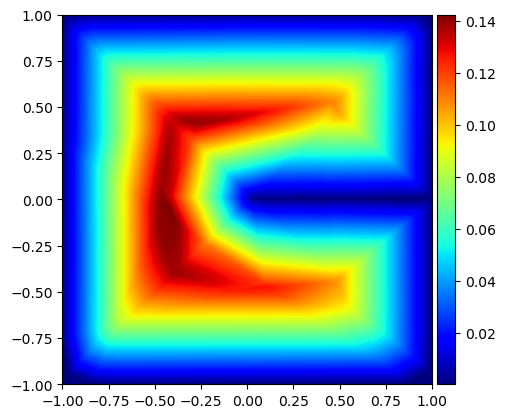

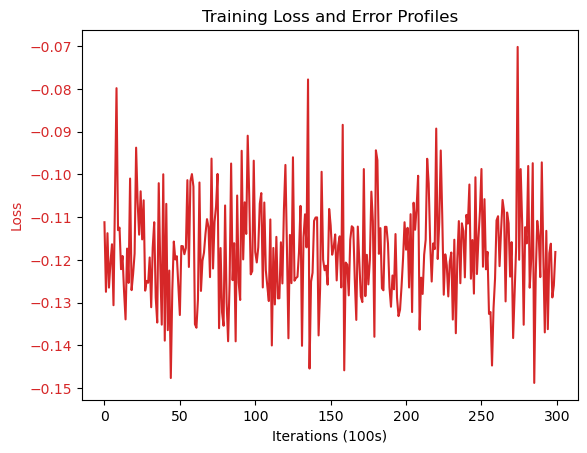

In [27]:
main_original(domain='original', arch='drfnn_ReLU', epochs=30000, pretrain=1)

### Feedforward NN, Tanh Activation

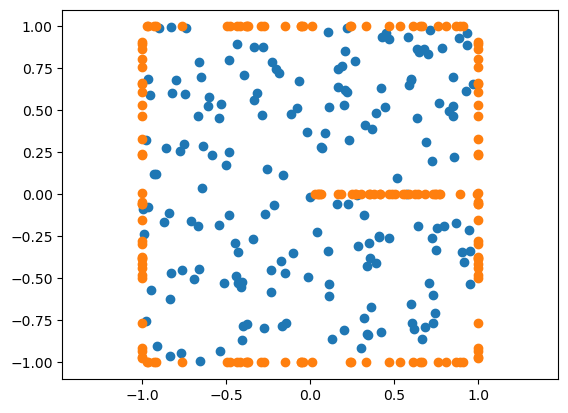

drfnn_Tanh


IntProgress(value=0, max=50)

epoch: 0 loss: 20.19976234436035 loss_r: 0.05028465762734413 loss_b: 20.149477005004883
epoch: 100 loss: 0.002560162916779518 loss_r: -0.0027264337986707687 loss_b: 0.005286596715450287
epoch: 200 loss: -0.0005679752212017775 loss_r: -0.0034098646137863398 loss_b: 0.0028418893925845623
epoch: 300 loss: -0.001292048953473568 loss_r: -0.0038065267726778984 loss_b: 0.0025144778192043304
epoch: 400 loss: -0.0029720135498791933 loss_r: -0.0058327047154307365 loss_b: 0.0028606911655515432
epoch: 500 loss: -0.002698803786188364 loss_r: -0.004787870682775974 loss_b: 0.0020890668965876102
epoch: 600 loss: -0.0026503242552280426 loss_r: -0.005431964993476868 loss_b: 0.002781640738248825
epoch: 700 loss: -0.0022110706195235252 loss_r: -0.005328036844730377 loss_b: 0.003116966225206852
epoch: 800 loss: -0.004244054201990366 loss_r: -0.00723227160051465 loss_b: 0.0029882173985242844
epoch: 900 loss: -0.003762228414416313 loss_r: -0.0069365049712359905 loss_b: 0.0031742765568196774
epoch: 1000 loss:

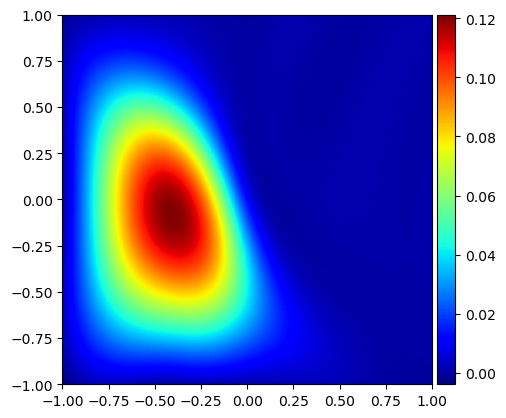

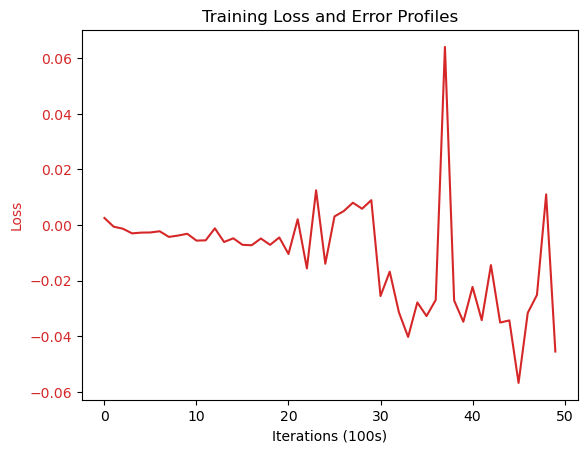

In [22]:
main_original(domain='original', arch='drfnn_Tanh', epochs=5000, pretrain=2)

drfnn_Tanh


IntProgress(value=0, max=250)

epoch: 0 loss: -0.03587399050593376 loss_r: -0.04591355100274086 loss_b: 0.010039559565484524
epoch: 100 loss: -0.002547225449234247 loss_r: -0.0061750104650855064 loss_b: 0.0036277850158512592
epoch: 200 loss: -0.008058926090598106 loss_r: -0.01493358239531517 loss_b: 0.006874655839055777
epoch: 300 loss: -0.009310344234108925 loss_r: -0.014771833084523678 loss_b: 0.005461488384753466
epoch: 400 loss: -0.01673327572643757 loss_r: -0.022026555612683296 loss_b: 0.00529327942058444
epoch: 500 loss: -0.015273265540599823 loss_r: -0.023273440077900887 loss_b: 0.008000174537301064
epoch: 600 loss: -0.013908863998949528 loss_r: -0.025632895529270172 loss_b: 0.011724031530320644
epoch: 700 loss: -0.02650047466158867 loss_r: -0.03556295856833458 loss_b: 0.009062484838068485
epoch: 800 loss: -0.026454227045178413 loss_r: -0.035726554691791534 loss_b: 0.009272327646613121
epoch: 900 loss: -0.02590065449476242 loss_r: -0.03831825032830238 loss_b: 0.012417595833539963
epoch: 1000 loss: -0.00827737

epoch: 8500 loss: -0.1455857753753662 loss_r: -0.1529141366481781 loss_b: 0.007328357547521591
epoch: 8600 loss: -0.131766676902771 loss_r: -0.1494038701057434 loss_b: 0.01763719692826271
epoch: 8700 loss: -0.10727724432945251 loss_r: -0.11711594462394714 loss_b: 0.00983869843184948
epoch: 8800 loss: -0.13043822348117828 loss_r: -0.1439826935529709 loss_b: 0.013544464483857155
epoch: 8900 loss: -0.10321579873561859 loss_r: -0.1243109181523323 loss_b: 0.021095121279358864
epoch: 9000 loss: -0.15111488103866577 loss_r: -0.1612834483385086 loss_b: 0.010168573819100857
epoch: 9100 loss: -0.09687711298465729 loss_r: -0.11212479323148727 loss_b: 0.015247680246829987
epoch: 9200 loss: -0.09756214171648026 loss_r: -0.10470904409885406 loss_b: 0.007146900054067373
epoch: 9300 loss: -0.14385275542736053 loss_r: -0.15277859568595886 loss_b: 0.008925839327275753
epoch: 9400 loss: -0.10666819661855698 loss_r: -0.11989574134349823 loss_b: 0.013227543793618679
epoch: 9500 loss: -0.1292898952960968 lo

epoch: 17000 loss: -0.15655025839805603 loss_r: -0.16596709191799164 loss_b: 0.009416830725967884
epoch: 17100 loss: -0.16530534625053406 loss_r: -0.17166514694690704 loss_b: 0.006359796039760113
epoch: 17200 loss: -0.14407655596733093 loss_r: -0.16137272119522095 loss_b: 0.017296159639954567
epoch: 17300 loss: -0.09362560510635376 loss_r: -0.10154558718204498 loss_b: 0.007919980213046074
epoch: 17400 loss: -0.1321038156747818 loss_r: -0.15246663987636566 loss_b: 0.020362818613648415
epoch: 17500 loss: -0.16885071992874146 loss_r: -0.17400531470775604 loss_b: 0.005154598969966173
epoch: 17600 loss: -0.1424163281917572 loss_r: -0.14957860112190247 loss_b: 0.007162266876548529
epoch: 17700 loss: -0.16273212432861328 loss_r: -0.1675112098455429 loss_b: 0.004779088776558638
epoch: 17800 loss: -0.12189660221338272 loss_r: -0.13242946565151215 loss_b: 0.010532866232097149
epoch: 17900 loss: -0.17281962931156158 loss_r: -0.17933489382266998 loss_b: 0.00651526777073741
epoch: 18000 loss: -0.09

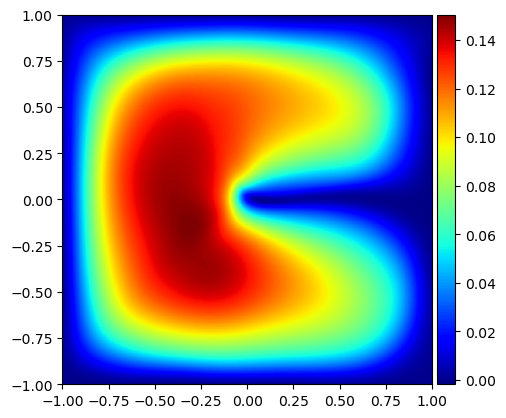

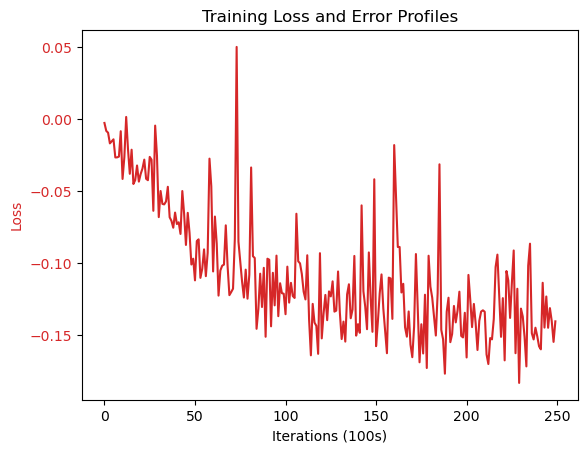

In [23]:
main_original(domain='original', arch='drfnn_Tanh', epochs=25000, pretrain=1)

drfnn_Tanh


IntProgress(value=0, max=300)

epoch: 0 loss: -0.12806622684001923 loss_r: -0.13724078238010406 loss_b: 0.009174560196697712
epoch: 100 loss: -0.13074609637260437 loss_r: -0.13350754976272583 loss_b: 0.0027614606078714132
epoch: 200 loss: -0.1218230351805687 loss_r: -0.12971176207065582 loss_b: 0.007888728752732277
epoch: 300 loss: -0.17713774740695953 loss_r: -0.18322116136550903 loss_b: 0.006083410698920488
epoch: 400 loss: -0.16111010313034058 loss_r: -0.18054170906543732 loss_b: 0.01943160779774189
epoch: 500 loss: -0.1396988034248352 loss_r: -0.16030101478099823 loss_b: 0.020602203905582428
epoch: 600 loss: -0.16193978488445282 loss_r: -0.1655299961566925 loss_b: 0.0035902122035622597
epoch: 700 loss: -0.12760987877845764 loss_r: -0.13996337354183197 loss_b: 0.01235349103808403
epoch: 800 loss: -0.13532772660255432 loss_r: -0.1457275003194809 loss_b: 0.01039977464824915
epoch: 900 loss: -0.16708029806613922 loss_r: -0.17739854753017426 loss_b: 0.010318242944777012
epoch: 1000 loss: -0.15780852735042572 loss_r: 

epoch: 8600 loss: -0.1579573154449463 loss_r: -0.16228799521923065 loss_b: 0.0043306732550263405
epoch: 8700 loss: -0.15305601060390472 loss_r: -0.1589757800102234 loss_b: 0.005919774994254112
epoch: 8800 loss: -0.14907114207744598 loss_r: -0.15881137549877167 loss_b: 0.009740232490003109
epoch: 8900 loss: -0.17488500475883484 loss_r: -0.1865442395210266 loss_b: 0.0116592301055789
epoch: 9000 loss: -0.13819357752799988 loss_r: -0.14326909184455872 loss_b: 0.005075508262962103
epoch: 9100 loss: -0.1612636297941208 loss_r: -0.17121663689613342 loss_b: 0.009953012689948082
epoch: 9200 loss: -0.1643543541431427 loss_r: -0.17608585953712463 loss_b: 0.011731510981917381
epoch: 9300 loss: -0.15252311527729034 loss_r: -0.16016007959842682 loss_b: 0.007636961527168751
epoch: 9400 loss: -0.11953603476285934 loss_r: -0.1289237141609192 loss_b: 0.00938768032938242
epoch: 9500 loss: -0.14889214932918549 loss_r: -0.16690587997436523 loss_b: 0.018013732507824898
epoch: 9600 loss: -0.15461337566375732

epoch: 17100 loss: -0.15297400951385498 loss_r: -0.16266147792339325 loss_b: 0.009687465615570545
epoch: 17200 loss: -0.1607266366481781 loss_r: -0.16371247172355652 loss_b: 0.002985835075378418
epoch: 17300 loss: -0.15171894431114197 loss_r: -0.16212774813175201 loss_b: 0.010408810339868069
epoch: 17400 loss: -0.12103196978569031 loss_r: -0.1277732402086258 loss_b: 0.006741273682564497
epoch: 17500 loss: -0.16672082245349884 loss_r: -0.17114071547985077 loss_b: 0.004419899545609951
epoch: 17600 loss: -0.170241117477417 loss_r: -0.17662875354290009 loss_b: 0.006387641653418541
epoch: 17700 loss: -0.08990021795034409 loss_r: -0.09390565007925034 loss_b: 0.004005432594567537
epoch: 17800 loss: -0.11589315533638 loss_r: -0.13394413888454437 loss_b: 0.01805098168551922
epoch: 17900 loss: -0.1448879837989807 loss_r: -0.14799483120441437 loss_b: 0.0031068543903529644
epoch: 18000 loss: -0.11932645738124847 loss_r: -0.12501317262649536 loss_b: 0.0056867147795856
epoch: 18100 loss: -0.13281357

epoch: 25600 loss: -0.1662919521331787 loss_r: -0.176110178232193 loss_b: 0.009818227030336857
epoch: 25700 loss: -0.14814941585063934 loss_r: -0.1492346078157425 loss_b: 0.0010851863771677017
epoch: 25800 loss: -0.13570153713226318 loss_r: -0.13959509134292603 loss_b: 0.0038935530465096235
epoch: 25900 loss: -0.14731484651565552 loss_r: -0.14962659776210785 loss_b: 0.002311751712113619
epoch: 26000 loss: -0.04348853975534439 loss_r: -0.092141292989254 loss_b: 0.04865275323390961
epoch: 26100 loss: -0.1451156735420227 loss_r: -0.15024064481258392 loss_b: 0.005124974530190229
epoch: 26200 loss: -0.16190733015537262 loss_r: -0.17163245379924774 loss_b: 0.009725121781229973
epoch: 26300 loss: -0.139381542801857 loss_r: -0.14733564853668213 loss_b: 0.007954100146889687
epoch: 26400 loss: -0.16139739751815796 loss_r: -0.16632431745529175 loss_b: 0.004926925990730524
epoch: 26500 loss: -0.1402391940355301 loss_r: -0.14755037426948547 loss_b: 0.0073111834935843945
epoch: 26600 loss: -0.163969

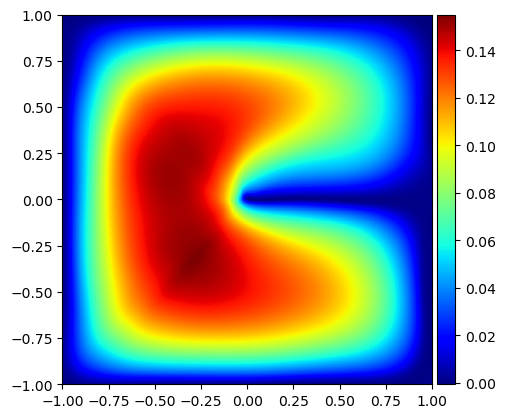

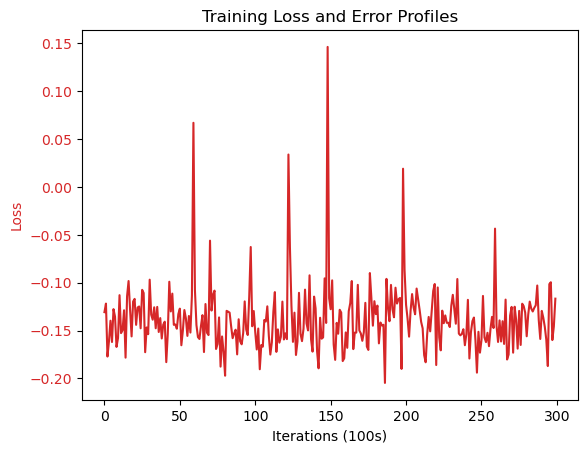

In [24]:
main_original(domain='original', arch='drfnn_Tanh', epochs=30000, pretrain=1)

--------------------------------------------------------------------------------------------------------------------------------